#UZOP - Projekt 2022./2023.
Birth weight prediction of new born baby with
application of machine learning techniques on
features of mother

Marta Bonacin, Petra Lončar, Lucija Marinčić


In [207]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

In [208]:
# Budite jako oprezni s korištenjem ove postavke! Ne preporuča se početnicima!
import warnings
warnings.filterwarnings('ignore')

# 1. Priprema i vizualizacija podataka

### Učitavanje podataka

In [209]:
from google.colab import drive
drive.mount('/content/drive')

X = pd.read_csv("drive/MyDrive/Colab Notebooks/CBWDB.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1. Početni pregled podataka

---



U našim podacima imamo 1800 primjera, 18 značajki i jednu izlaznu oznaku.

In [210]:
X.shape

(1800, 19)

In [211]:
# prikaz skupa za treniranje
X.head()

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Term/Preterm,Sex,BWt(kg),LNH
0,BPL,23.0,146.0,A(+ve),1.0,4.0,34.0,42.0,116.0,78.0,120.0,70.0,10.0,13.2,90.0,T,F,2.7,2.0
1,BPL,25.0,165.0,NIL,1.0,3.0,68.0,71.0,96.0,70.0,110.0,72.0,10.4,11.0,96.0,T,M,2.9,2.0
2,BPL,24.0,155.0,B(+ve),1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,T,M,2.4,1.0
3,BPL,19.0,154.0,NIL,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,T,F,2.6,2.0
4,BPL,21.0,150.0,NIL,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,T,F,2.3,1.0


In [212]:
#preimenovane značajke kako bismo im lakše pristupali
X.rename(columns = {'Age(years)':'Age', 'Height(cm)':'Height', 
                        'Iwt(kg)':'Iwt', 'FWt(kg)':'FWt', 'IHb(gm%)':'IHb', 
                        'FHb(gm%)':'FHb', 'BS(RBS)':'BS', 'Term/Preterm':'TermPreterm', 'BWt(kg)':'BWt'}, inplace = True)
X.columns.values

array(['SEC', 'Age', 'Height', 'Bgroup', 'Parity', 'ANC', 'Iwt', 'FWt',
       'IBP_sys', 'IBP_dias', 'FBP_sys', 'FBP_dias', 'IHb', 'FHb', 'BS',
       'TermPreterm', 'Sex', 'BWt', 'LNH'], dtype=object)

Pojašnjenja značajki:
 - SEC - socioekonomski status (APL-Above Poverty line ili BPL-Below Poverty line)

 - Age(years) - dob majke za vrijeme trudnoće
 - Height(cm) - visina majke za vrijeme trudnoće
 - Bgroup - krvna grupa majke
 - Parity - broj prethodnih trudnoća
 - ANC - antenatalni pregled
 - Iwt(kg) - početna težina majke
 - FWt(kg) - konačna težina majke (posljednji antenatalni pregled)
 - IBP_sys - početni sistolički krvni tlak majke
 - IBP_dias - početni dijastolički krvni tlak majke
 - FBP_sys - konačni sistolički tlak majke (posljednji antenatalni pregled)
 - FBP_dias - konačni dijastolički krvni tlak majke (posljednji antenatalni pregled)
 - IHb(gm%) - početna razina hemoglobina majke
 - FHb(gm%) - konačna razina hemoglobina majke (posljednji antenatalni pregled)
 - BS(RBS) - šećer u krvi majke
 - Term/Preterm - na vrijeme (Term): 37 do 40 tjedana, prijevremeni (Preterm): < 37 tjedana
 - Sex - spol novorođenčeta (M, F ili T)
 - BWt(kg) - težina novorođenčeta

Izlazna oznaka:
- LNH - oznaka težine novorođenčeta (L-ispodprosječna težina, N-normalna težina)

In [213]:
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,1786.0,22.986002,4.050843,8.0,20.0,22.0,25.0,55.0
Height,1527.0,143.785855,19.702879,10.0,135.0,150.0,150.0,195.0
Parity,1767.0,0.667233,0.993277,0.0,0.0,0.0,1.0,6.0
ANC,1781.0,3.423358,0.889005,1.0,3.0,4.0,4.0,4.0
Iwt,1751.0,45.749857,6.655457,30.0,41.0,45.0,50.0,93.0
FWt,1739.0,51.645371,6.905943,30.0,47.0,51.0,55.0,100.0
IBP_sys,1760.0,108.032386,12.021658,10.0,100.0,110.0,112.0,196.0
IBP_dias,1760.0,66.091477,8.263232,14.0,60.0,66.0,70.0,100.0
FBP_sys,1749.0,111.819325,11.809435,10.0,110.0,110.0,120.0,160.0
FBP_dias,1748.0,69.405606,9.249682,10.0,60.0,70.0,78.0,117.0


## 1.2. Monotone značajke
Provjerimo postoje li monotone značajke, odnosno značajke čija vrijednost jednoliko raste (ili se smanjuje).

In [214]:
X.nunique()

SEC             2
Age            28
Height         59
Bgroup         13
Parity          7
ANC             4
Iwt            45
FWt            48
IBP_sys        59
IBP_dias       48
FBP_sys        55
FBP_dias       52
IHb            55
FHb            52
BS             83
TermPreterm     3
Sex             3
BWt            36
LNH             3
dtype: int64

Možemo zaključiti po funkciji nunique da u našim podacima nema monotonih značajki.

## 1.3. Nedostajući podatci

Nedostajući podaci su podaci kojima vrijednost nije unesena u skup podataka te kao takvi predstavljaju problem. Provjerimo koliko je takvih podataka te analizirajmo kako bismo se riješili tog problema.

In [215]:
X.isna().sum()

SEC             650
Age              14
Height          273
Bgroup         1002
Parity           33
ANC              19
Iwt              49
FWt              61
IBP_sys          40
IBP_dias         40
FBP_sys          51
FBP_dias         52
IHb             405
FHb             407
BS             1192
TermPreterm     838
Sex             658
BWt             728
LNH             728
dtype: int64

Generalno, opcije za rješavanje problema nedostajućih vrijednosti su:
 - zamijeniti srednjom vrijednošću (samo kod numerička vrijednosti)
 - u potpunosti izbaciti te zapise iz skupa podataka (ako je velika količina podataka nećemo jer gubimo previše informacija)
 - u potpunosti izbaciti te značajke iz skupa podataka
 - interpolacija (samo kada je numerička vrijednost)
 - pronalazak točnih vrijednosti iz drugih izvora podataka (najbolje, ali ne možemo tek tako doći do tih informacija)

Dakle kod naših podataka, problem nedostajućih podataka ćemo riješiti:
- zamjenom srednjom vrijednošću za značajke:  Age, Height, IHb, FHb, BS, BWt, LNH 
- izbacivanjem zapisa iz skupa podataka za značajke: Parity, ANC, Iwt, FWt, IBP_sys, IBP_dias, FBP_sys, FBP_dias
- izbacivanjem značajke iz skupa podataka: SEC, Bgroup, Term/Preterm, Sex


In [216]:
X_tmp = X.copy()

# ubaci srednju vrijednost tamo gdje nedostaje ta informacija
X_tmp.loc[X_tmp.Age.isna(),'Age'] = X_tmp.loc[:,'Age'].mean()
X_tmp.loc[X_tmp.Height.isna(),'Height'] = X_tmp.loc[:,'Height'].mean()
X_tmp.loc[X_tmp.IHb.isna(),'IHb'] = X_tmp.loc[:,'IHb'].mean()
X_tmp.loc[X_tmp.FHb.isna(),'FHb'] = X_tmp.loc[:,'FHb'].mean()
X_tmp.loc[X_tmp.BS.isna(),'BS'] = X_tmp.loc[:,'BS'].mean()
#X_tmp.loc[X_tmp.BWt.isna(),'BWt'] = X_tmp.loc[:,'BWt'].mean()
#X_tmp.loc[X_tmp.LNH.isna(), 'LNH'] = round(X_tmp.loc[:,'LNH'].mean())


# izbaci stupac tj. značajku --> izbacujemo ih jer za prevelik broj primjera nisu definirane
X_tmp.drop(['SEC'], axis=1, inplace=True)
X_tmp.drop(['Bgroup'], axis=1, inplace=True)
X_tmp.drop(['TermPreterm'], axis=1, inplace=True)
X_tmp.drop(['Sex'], axis=1, inplace=True)

# izbaci zapise s nedostajućom vrijednosti značajke (postotak podataka koje gubimo)
X_tmp = X_tmp.loc[X_tmp.Parity.notnull(), :]  # 1.83% podataka
X_tmp = X_tmp.loc[X_tmp.ANC.notnull(), :] # 1.06% podataka
X_tmp = X_tmp.loc[X_tmp.Iwt.notnull(), :] # 2.72% podataka
X_tmp = X_tmp.loc[X_tmp.FWt.notnull(), :] # 3.39% podataka
X_tmp = X_tmp.loc[X_tmp.IBP_sys.notnull(), :] # 2.22% podataka
X_tmp = X_tmp.loc[X_tmp.IBP_dias.notnull(), :]  # 2.22% podataka
X_tmp = X_tmp.loc[X_tmp.FBP_sys.notnull(), :] #2.83% podataka
X_tmp = X_tmp.loc[X_tmp.FBP_dias.notnull(), :] #  2.89% podataka
X_tmp = X_tmp.loc[X_tmp.BWt.notnull(), :]


Provjerimo jesmo li uspjeli očistiti podatke od nepostojećih podataka.

In [217]:
X_tmp.isna().sum()

Age         0
Height      0
Parity      0
ANC         0
Iwt         0
FWt         0
IBP_sys     0
IBP_dias    0
FBP_sys     0
FBP_dias    0
IHb         0
FHb         0
BS          0
BWt         0
LNH         0
dtype: int64

Dakle značajke koje su preostale su:

In [218]:
X_tmp.columns.values

array(['Age', 'Height', 'Parity', 'ANC', 'Iwt', 'FWt', 'IBP_sys',
       'IBP_dias', 'FBP_sys', 'FBP_dias', 'IHb', 'FHb', 'BS', 'BWt',
       'LNH'], dtype=object)

In [219]:
X_tmp.shape

(1058, 15)

Ispravljanjem nedostajućih podataka prešli smo s 1800 primjera na 1058.

## 1.4. Stršeći podatci

Metodom describe možemo za početak vidjeti ima li stršećih vrijednosti u podacima. Uspoređujemo srednju vrijednost (mean) s minimalnom (min) i maksimalnom vrijednosti (max). No također ćemo imati bolji pregled stršećih vrijednosti vizualizacijom podataka npr. pomoću kutijastog grafa (box plot).

In [220]:
X_tmp.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,1058.0,22.850622,4.313012,8.0,20.000000,22.000000,25.0,55.0
Height,1058.0,142.407996,17.129651,10.0,137.000000,145.000000,150.0,195.0
Parity,1058.0,0.596408,0.937330,0.0,0.000000,0.000000,1.0,6.0
ANC,1058.0,3.731569,0.604121,1.0,4.000000,4.000000,4.0,4.0
Iwt,1058.0,45.599244,6.777870,30.0,41.000000,45.000000,50.0,77.0
FWt,1058.0,52.520132,6.686397,34.0,48.000000,52.000000,56.0,81.0
IBP_sys,1058.0,105.920605,12.409038,10.0,100.000000,110.000000,110.0,188.0
IBP_dias,1058.0,65.919660,7.735344,40.0,60.000000,68.000000,70.0,100.0
FBP_sys,1058.0,111.095463,13.193106,10.0,110.000000,110.000000,120.0,150.0
FBP_dias,1058.0,70.680529,8.605405,40.0,62.000000,70.000000,80.0,117.0


Temeljem ovog ispisa kandidati za stršeće vrijednosti su Height i Parity. Jednom kada pronađemo stršeće vrijednosti potrebno ih je ukloniti ako se stručnjaci slože da ne prikazuju prirodno stanje.



In [221]:
print('Height < 20: ', (X_tmp.Height < 20).sum())
print('Height < 40: ', (X_tmp.Height < 40).sum())
print('Height < 60: ', (X_tmp.Height < 60).sum())
print('Height < 80: ', (X_tmp.Height < 80).sum())
print('Height < 100: ', (X_tmp.Height < 100).sum())

print()
print('Parity > 1: ', (X_tmp.Parity > 1).sum())
print('Parity > 2: ', (X_tmp.Parity > 2).sum())
print('Parity > 3: ', (X_tmp.Parity > 3).sum())
print('Parity > 4: ', (X_tmp.Parity > 4).sum())
print('Parity > 5: ', (X_tmp.Parity > 5).sum())

Height < 20:  1
Height < 40:  1
Height < 60:  2
Height < 80:  3
Height < 100:  20

Parity > 1:  161
Parity > 2:  59
Parity > 3:  12
Parity > 4:  3
Parity > 5:  2


In [222]:
X_tmp.loc[X_tmp.Height < 80, 'Height']
X_tmp.loc[X_tmp.Parity > 5, 'Parity']

21      6.0
1733    6.0
Name: Parity, dtype: float64

## 1.5. Nekonzistentni podatci
Bilo kakav slobodan unos teksta često dovodi do nekonzistentnosti u podatcima.

In [223]:
pd.crosstab(X['Bgroup'], X['Sex'])

Sex,F,M
Bgroup,,
A(+VE),2,1
A(+ve),46,63
A(-ve),0,1
AB(+ve),29,26
AB(-ve),0,1
B(+VE),0,4
B(+ve),95,73
B(-ve),2,0
B+(+ve),0,1


Možemo uočiti kako su iste krvne grupe razdijeljene. Iako podaci predstavljaju istu informaciju drugačije se tumače zbog nekonzistentnosti u nazivu. Tako npr. krvna grupa A(+ve) i A(+VE) u stvarnosti predstavljaju istu krvnu grupu.

In [224]:
# zamijeni nekonzistentne krvne grupe
X['Bgroup'] = X['Bgroup'].replace('A(+VE)', 'A(+ve)')
X['Bgroup'] = X['Bgroup'].replace('B(+VE)', 'B(+ve)')
X['Bgroup'] = X['Bgroup'].replace('O(+VE)', 'O(+ve)')
X['Bgroup'] = X['Bgroup'].replace('B+(+ve)', 'B(+ve)')

Prikažimo koje je težine novorođenče u ovisnosti o krvnoj grupi majke.

In [225]:
X[['Bgroup', 'BWt']].groupby(['Bgroup'], as_index=False).mean()


,Bgroup,BWt
0,A(+ve),2.821053
1,A(-ve),2.600000
2,AB(+ve),2.785185
3,AB(-ve),2.500000
4,B(+ve),2.776627
5,B(-ve),2.950000
6,NIL,2.677174
7,O(+ve),2.795113
8,O(-ve),3.200000


## 1.6. Dijagrami
Pomoću različitih tipova dijagrama nastojat ćemo vizualizirati podatke. Na ovaj način također možemo dobiti i intuiciju o ovisnosti značajki.

### 1.6.1. Histogram

Pogledajmo prvo podatke o majkama.

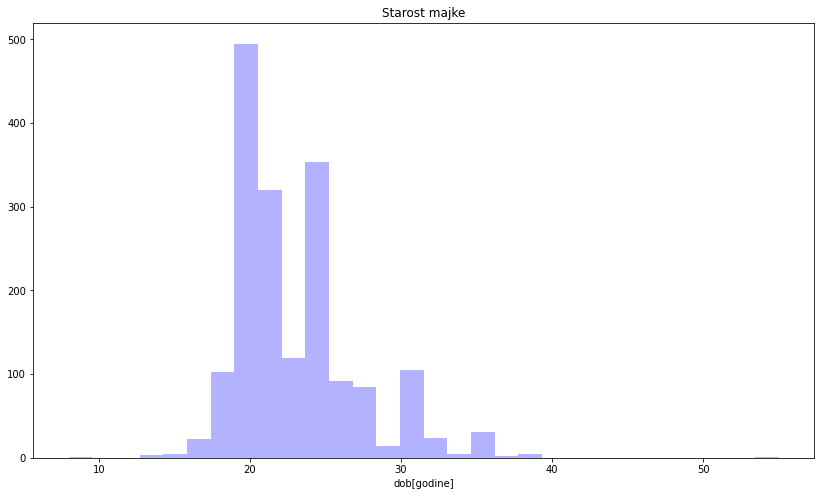

In [226]:
plt.figure(figsize=(14,8))

plt.hist(X.Age, bins=30, color='blue', alpha=0.3)
plt.title('Starost majke')
plt.xlabel('dob[godine]')
plt.show()

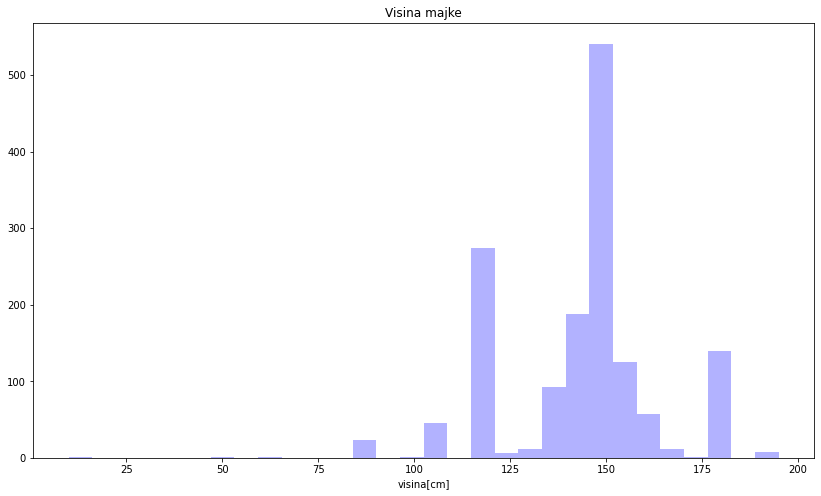

In [227]:
plt.figure(figsize=(14,8))
plt.hist(X.Height, bins=30, color='blue', alpha=0.3)
plt.title('Visina majke')
plt.xlabel('visina[cm]')
plt.show()

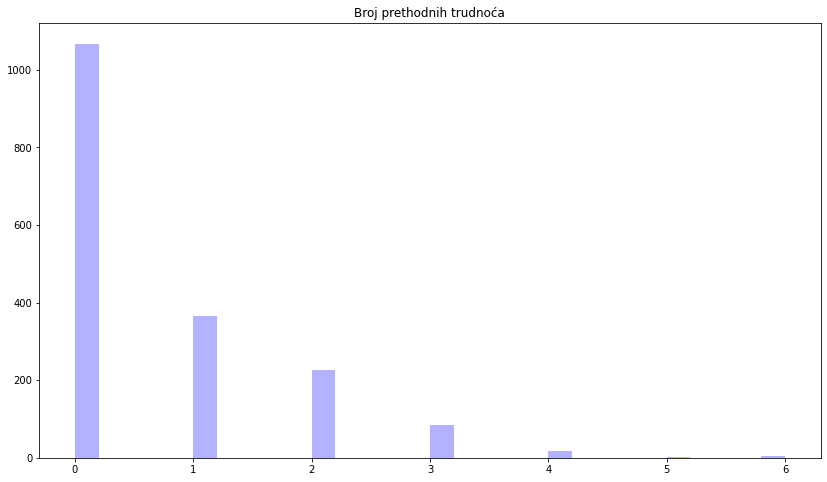

In [228]:
plt.figure(figsize=(14,8))
plt.hist(X.Parity, bins=30, color='blue', alpha=0.3)
plt.title('Broj prethodnih trudnoća')
plt.show()

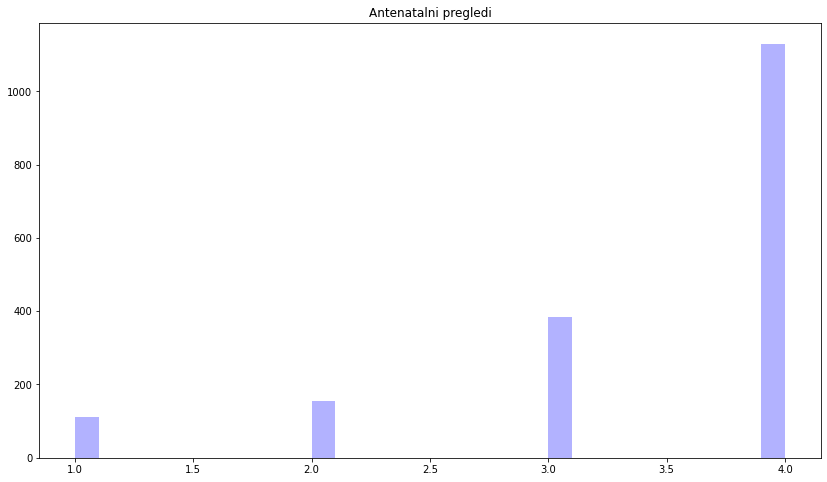

In [229]:
plt.figure(figsize=(14,8))
plt.hist(X.ANC, bins=30, color='blue', alpha=0.3)
plt.title('Antenatalni pregledi')
plt.show()

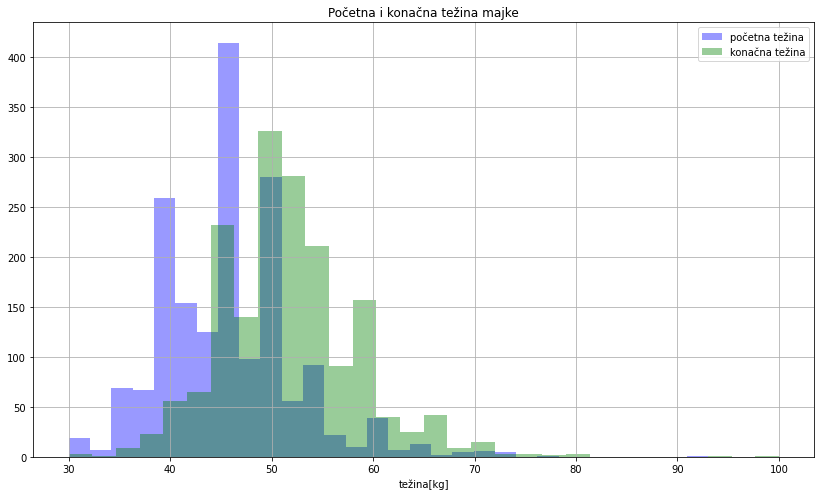

In [230]:
plt.figure(figsize=(14,8))
plt.title("Početna i konačna težina majke")
plt.hist(X.Iwt, bins=30, color='blue', label='početna težina', alpha=0.4)
plt.xlabel("težina[kg]")
plt.hist(X.FWt, bins=30, color='green', label='konačna težina', alpha=0.4)
plt.legend(loc='best')
plt.grid(b=None)
plt.show()

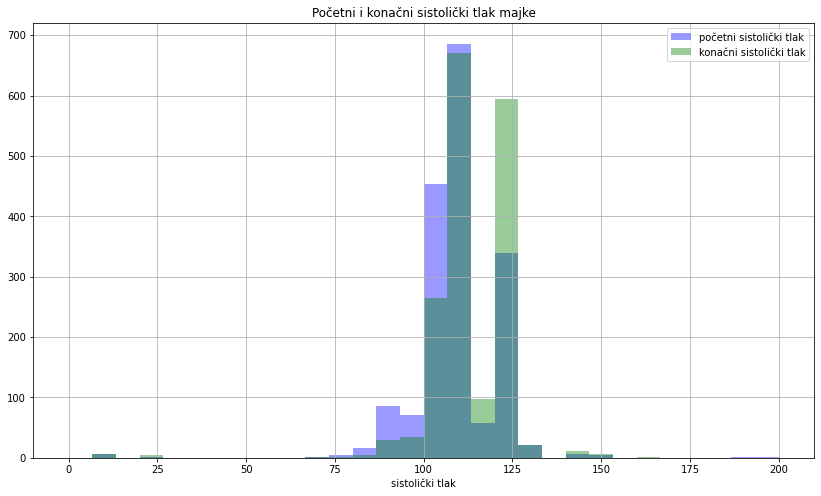

In [231]:
plt.figure(figsize=(14,8))
plt.title("Početni i konačni sistolički tlak majke")
plt.xlabel("sistolički tlak")
plt.hist(X.IBP_sys, bins=30, range=(0, 200), label="početni sistolički tlak", color="blue", alpha=0.4)
plt.hist(X.FBP_sys, bins=30, range=(0, 200), label="konačni sistolički tlak", color="green", alpha=0.4)
plt.legend(loc="best")
plt.grid(b=None)
plt.show()

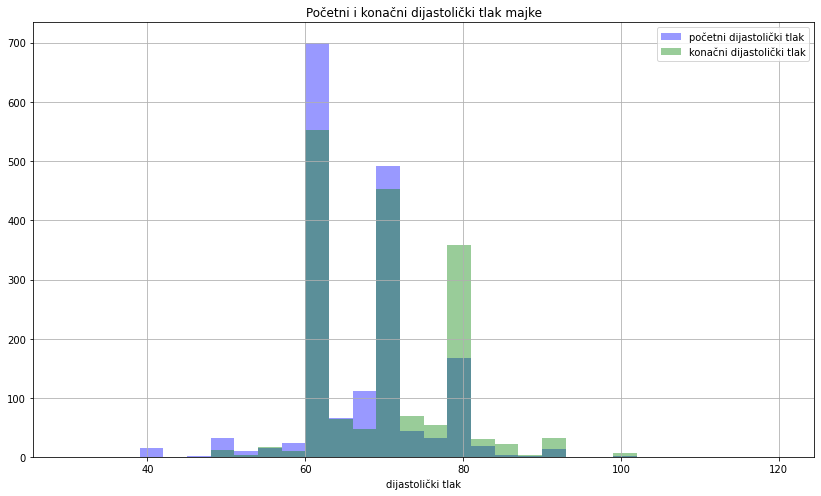

In [232]:
plt.figure(figsize=(14,8))
plt.title("Početni i konačni dijastolički tlak majke")
plt.xlabel("dijastolički tlak")
plt.hist(X.IBP_dias, bins=30, range=(30, 120), label="početni dijastolički tlak", color="blue", alpha=0.4)
plt.hist(X.FBP_dias, bins=30, range=(30, 120), label="konačni dijastolički tlak", color="green", alpha=0.4)
plt.legend(loc="best")
plt.grid(b=None)
plt.show()

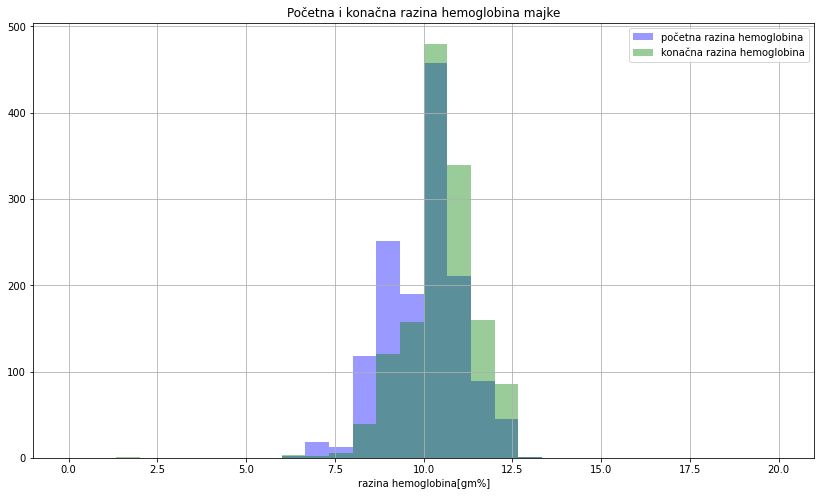

In [233]:
plt.figure(figsize=(14,8))
plt.title("Početna i konačna razina hemoglobina majke")
plt.xlabel("razina hemoglobina[gm%]")
plt.hist(X.IHb, bins=30, range=(0, 20), label="početna razina hemoglobina", color="blue", alpha=0.4)
plt.hist(X.FHb, bins=30, range=(0, 20), label="konačna razina hemoglobina", color="green", alpha=0.4)
plt.legend(loc="best")
plt.grid(b=None)
plt.show()

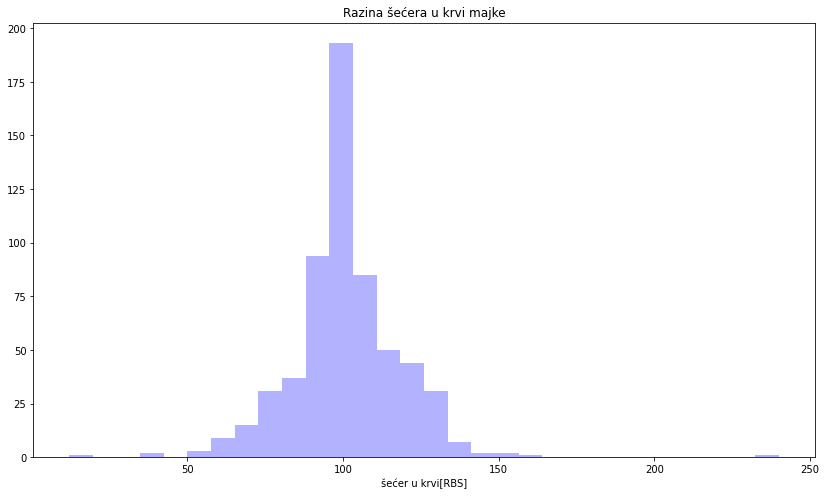

In [234]:
plt.figure(figsize=(14,8))
plt.hist(X.BS, bins=30, color='blue', alpha=0.3)
plt.title('Razina šećera u krvi majke')
plt.xlabel('šećer u krvi[RBS]')
plt.show()

Sljedeće možemo pogledati raspodijelu težina beba. 

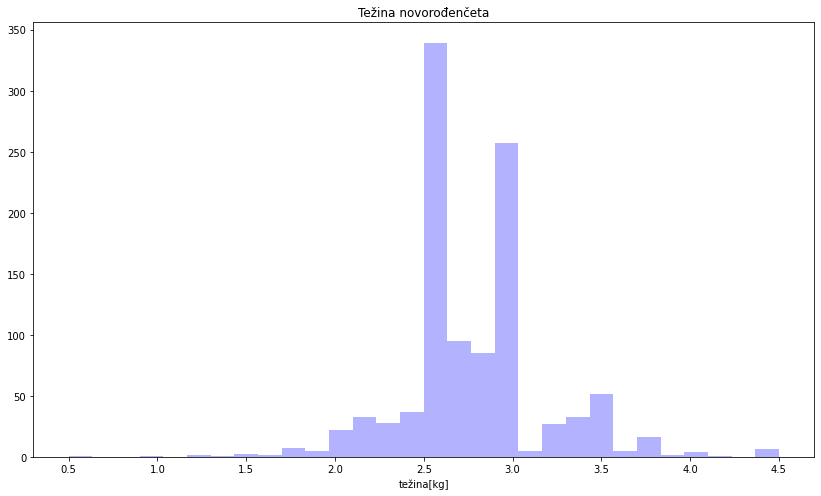

In [235]:
plt.figure(figsize=(14,8))
plt.hist(X.BWt, bins=30, color='blue', alpha=0.3)
plt.title('Težina novorođenčeta')
plt.xlabel('težina[kg]')
plt.show()

### 1.6.2. Pitni graf
Pitni graf smo koristili za prikazati nenumeričke značajke.

Pogledajmo kakva je podijela krvnih grupa majki.

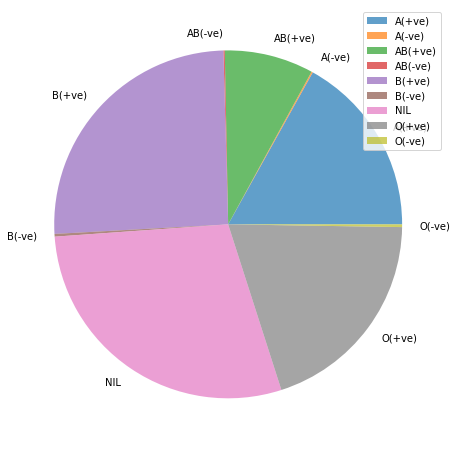

In [236]:
count = X.groupby('Bgroup').size()
types = X.groupby('Bgroup').count().index.values

plt.figure(figsize=(14,8))
plt.pie(count, labels=types, wedgeprops={'alpha':0.7})
plt.legend(loc='best')
plt.show()

Pitni graf koji daje prikaz spola djece.

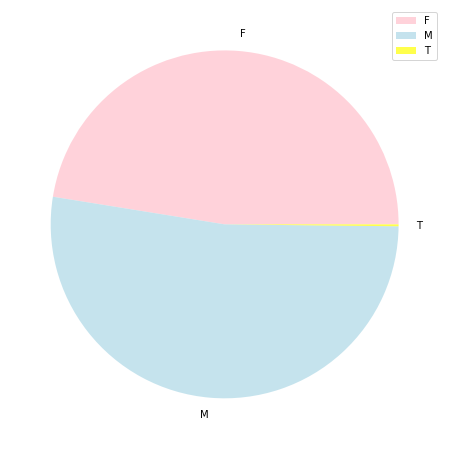

In [237]:
count = X.groupby('Sex').size()
names = X.groupby('Sex').count().index.values

colors = ['pink','lightblue','yellow']

plt.figure(figsize=(14,8))
plt.pie(count, labels=names, colors=colors, wedgeprops={'alpha':0.7})
plt.legend(loc='best')
plt.show()

Pitni graf koji opisuje distribuciju podataka ovisno o socioekonomskom statusu majke

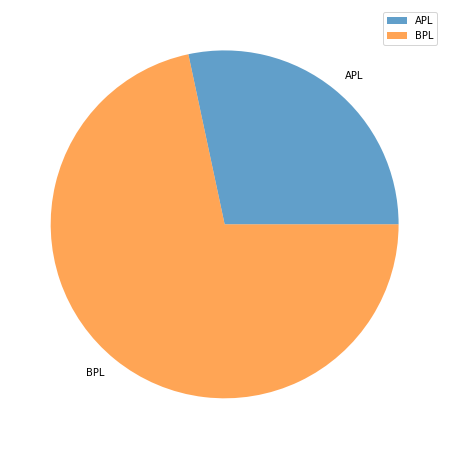

In [238]:
count = X.groupby('SEC').size()
names = X.groupby('SEC').count().index.values

plt.figure(figsize=(14,8))
plt.pie(count, labels=names, wedgeprops={'alpha':0.7})
plt.legend(loc='best')
plt.show()

Pitni graf koji nam prikazuje postotak majki koje su rodile prije definiranog termina (PT, < 37 tjedana) te postotak majki koje su rodile za definiranog termina poroda (T, 37-40 tjedana).

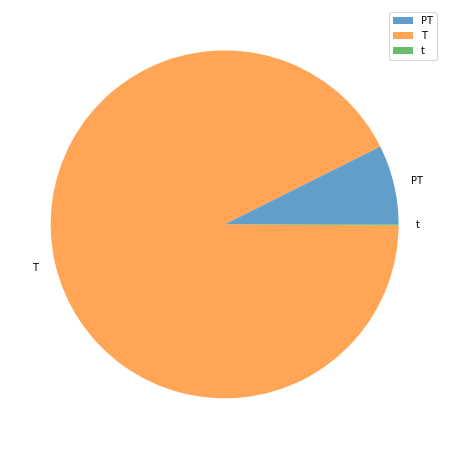

In [239]:
count = X.groupby('TermPreterm').size()
names = X.groupby('TermPreterm').count().index.values

plt.figure(figsize=(14,8))
plt.pie(count, labels=names, wedgeprops={'alpha':0.7})
plt.legend(loc='best')
plt.show()

Pitni graf koji opisuje vrijednosti izlazne oznake LNH.

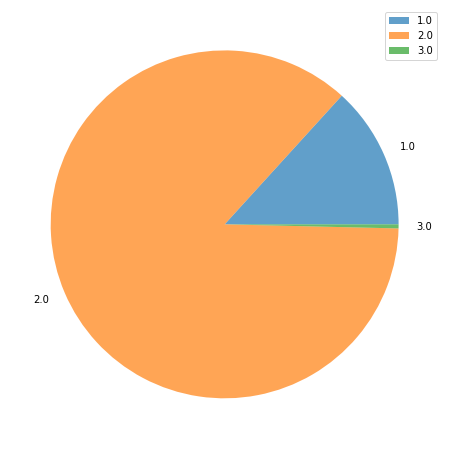

In [240]:
count = X.groupby('LNH').size()
names = X.groupby('LNH').count().index.values

plt.figure(figsize=(14,8))
plt.pie(count, labels=names, wedgeprops={'alpha':0.7})
plt.legend(loc='best')
plt.show()

### 1.6.3. Stupičasti graf

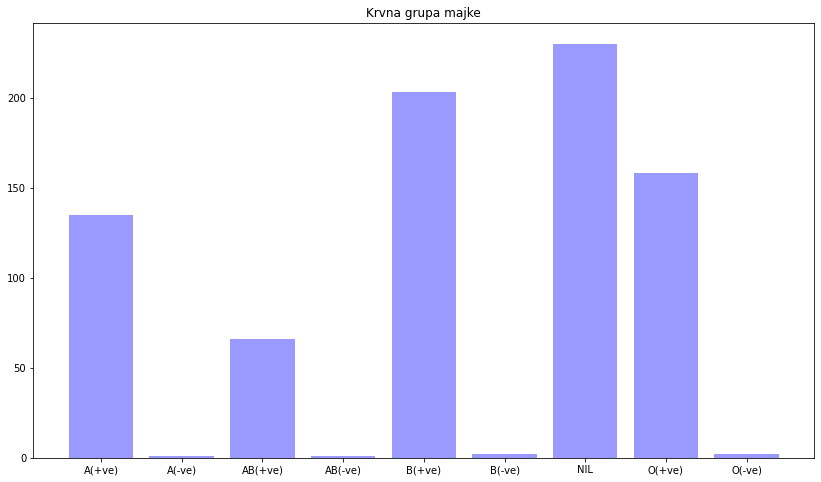

In [241]:
count = X.groupby('Bgroup').size()
names = X.groupby('Bgroup').count().index.values

plt.figure(figsize=(14,8))
plt.title('Krvna grupa majke')
plt.bar(names, count, color='blue', alpha=0.4)
plt.show()

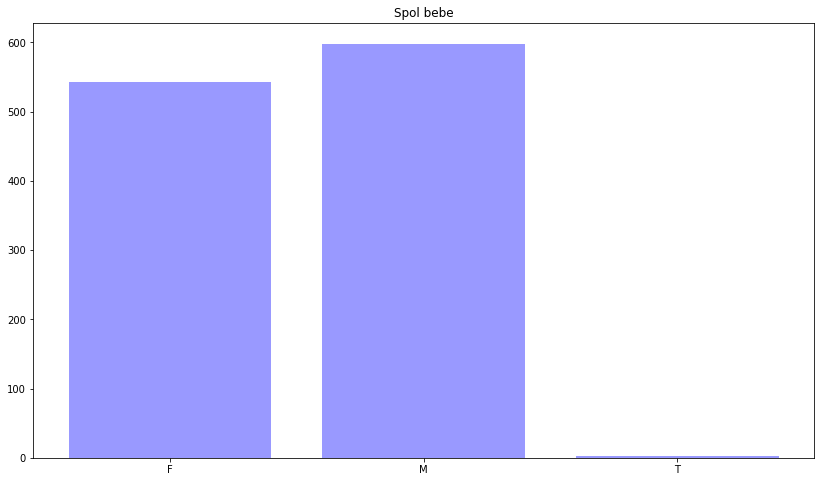

In [242]:
count = X.groupby('Sex').size()
names = X.groupby('Sex').count().index.values

plt.figure(figsize=(14,8))
plt.title('Spol bebe')
plt.bar(names, count, color='blue', alpha=0.4)
plt.show()

Zanimljivo bi bilo pogledati koliko je majki rodilo u terminu, a koliko prije termina u ovisnosti o socioekonomskom statusu.

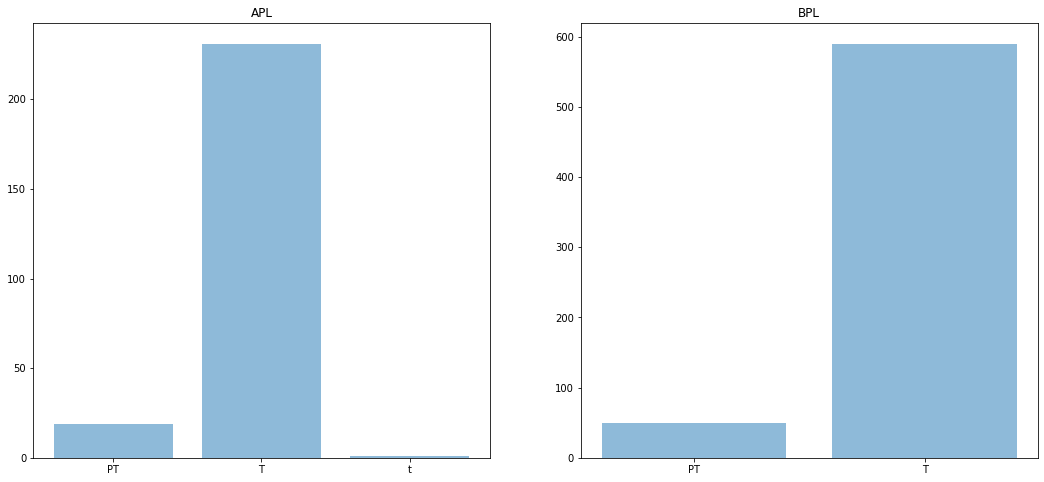

In [243]:
plt.figure(figsize=(18,8))
apl = X.SEC == 'APL'
bpl = X.SEC == 'BPL'

countApl = X.loc[apl].groupby('TermPreterm').size()
namesApl = X.loc[apl].groupby('TermPreterm').count().index.values

countBpl = X.loc[bpl].groupby('TermPreterm').size()
namesBpl = X.loc[bpl].groupby('TermPreterm').count().index.values

plt.subplot(1,2,1)
plt.title('APL')
plt.bar(namesApl, countApl, alpha=0.5, label='apl')
plt.subplot(1,2,2)
plt.title('BPL')
plt.bar(namesBpl, countBpl, alpha=0.5, label='bpl')
plt.show()


Možemo zaključiti da je više poroda sa strane majki nižeg socioekonomskog statusa no omjeri poroda prije termina i u terminu su slični. Za oba slučaja su otprilike 1:12.

### 1.6.4. Kutijasti graf (Box plot)
 Koristimo kutijaste grafove kako bismo dobili vizualnu reprezentaciju podataka i detektirali stršeće vrijednosti.

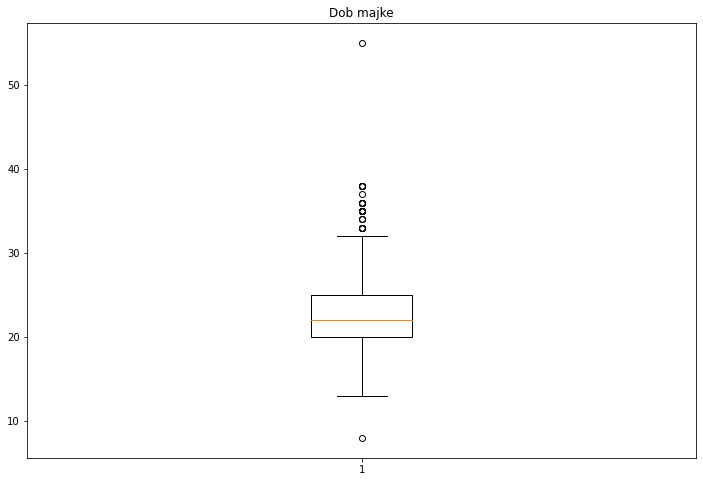

In [244]:
plt.figure(figsize=(12,8))
plt.boxplot(X_tmp.Age)
plt.title('Dob majke')
plt.show()

Možemo vidjeti kako imamo primjer majke koja je rodila sa 55 godina i majke koja je rodila s 8 godina. Ovi primjeri su ekstremi i javljaju se u malom broju, stoga nam nisu od velike koristi pri donošenju zaključka o težini bebe u ovisnosti o karakteristikama majke.

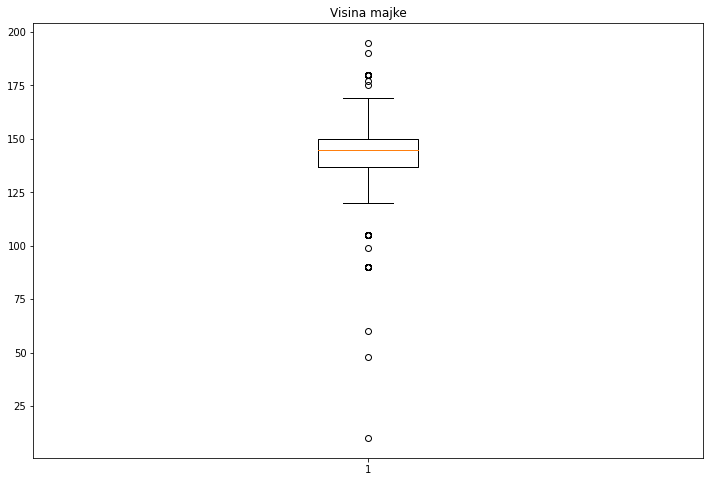

In [245]:
plt.figure(figsize=(12,8))
plt.boxplot(X_tmp.Height)
plt.title('Visina majke')
plt.show()

Što se tiče visine majke također imamo ekstreme za koje možemo zaključiti da su neispravni podaci, npr. majke koje su niže od 100cm. 

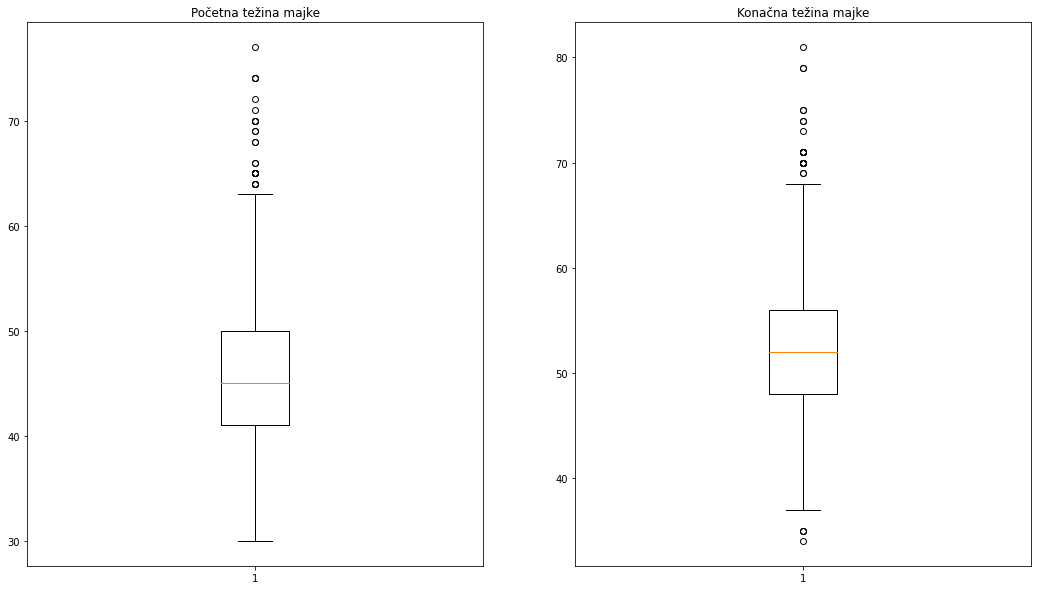

In [246]:
plt.figure(figsize=(18,10))
plt.subplot(1, 2, 1)
plt.boxplot(X_tmp.Iwt)
plt.title('Početna težina majke')
plt.subplot(1, 2, 2)
plt.boxplot(X_tmp.FWt)
plt.title('Konačna težina majke')
plt.show()

Za težinu majke imamo ekstremne vrijednosti konačne težinu majke. Ne mora nužno značiti da su ovi podaci neispravni, majke mogu biti pothranjene pogotovo ako su slabijeg socioekonomskog statusa.

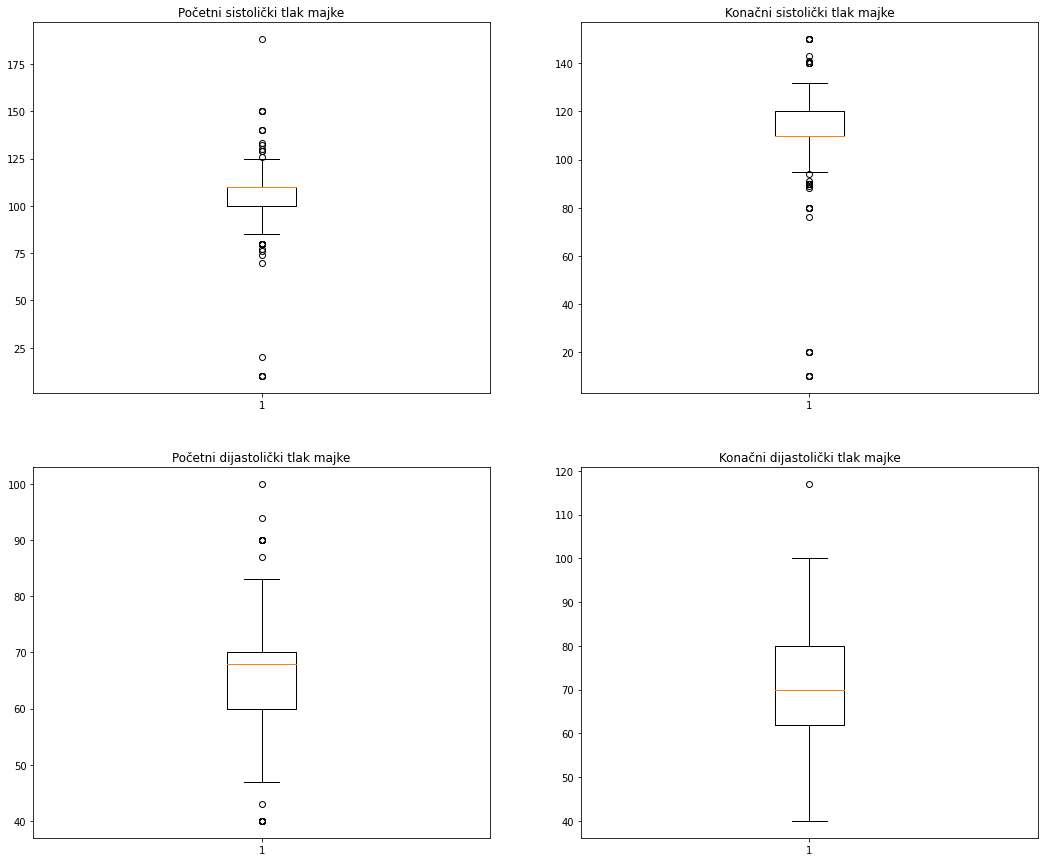

In [247]:
plt.figure(figsize=(18,15))
plt.subplot(2, 2, 1)
plt.boxplot(X_tmp.IBP_sys)
plt.title('Početni sistolički tlak majke')
plt.subplot(2, 2, 2)
plt.boxplot(X_tmp.FBP_sys)
plt.title('Konačni sistolički tlak majke')
plt.subplot(2, 2, 3)
plt.boxplot(X_tmp.IBP_dias)
plt.title('Početni dijastolički tlak majke')
plt.subplot(2, 2, 4)
plt.boxplot(X_tmp.FBP_dias)
plt.title('Konačni dijastolički tlak majke')
plt.show()

Sistolički tlak predstavlja viši krvni tlak dok dijastolički tlak predstavlja niži krvni tlak. Također uočavamo vrijednosti koje odstupaju no ne možemo tek tako zaključiti jesu li te vrijednosti rezultat neispravnog unosa ili se radi o majkama koje kao posljedica nekakve bolesti imaju abnormalni krvni tlak. Kako bismo bili sigurni o čemu se radi bilo bi dobro kontaktirati stručnjake tog područja.

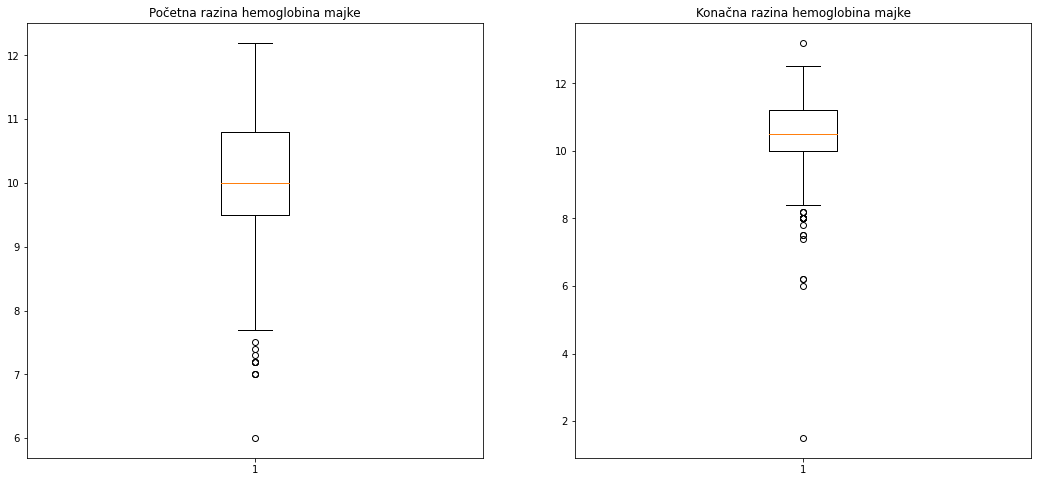

In [248]:
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
plt.boxplot(X_tmp.IHb)
plt.title('Početna razina hemoglobina majke')
plt.subplot(1, 2, 2)
plt.boxplot(X_tmp.FHb)
plt.title('Konačna razina hemoglobina majke')
plt.show()

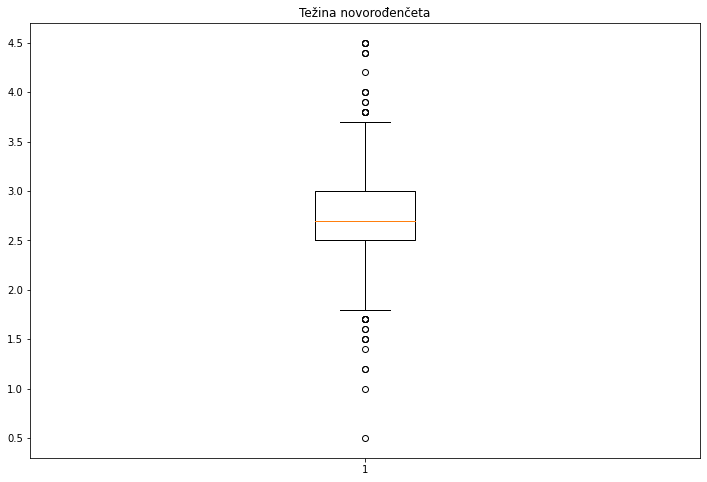

In [249]:
plt.figure(figsize=(12,8))
plt.boxplot(X_tmp.BWt)
plt.title('Težina novorođenčeta')
plt.show()

### 1.6.5. Toplinska mapa
Toplinskom mapom možemo vidjeti koreliranost među različitim značajkama.

Kako bismo mogli pogledati koreliranost i nenumeričkih značajki prebacujemo ih pomoću encodera u numeričke vrijednosti.

In [250]:
leTP = LabelEncoder()
leTP.fit(X.loc[:,'TermPreterm'])

X.loc[:,'TermPreterm'] = leTP.transform(X.loc[:,'TermPreterm'])
X.head()

,SEC,Age,Height,Bgroup,Parity,ANC,Iwt,FWt,IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb,FHb,BS,TermPreterm,Sex,BWt,LNH
0,BPL,23.0,146.0,A(+ve),1.0,4.0,34.0,42.0,116.0,78.0,120.0,70.0,10.0,13.2,90.0,1,F,2.7,2.0
1,BPL,25.0,165.0,NIL,1.0,3.0,68.0,71.0,96.0,70.0,110.0,72.0,10.4,11.0,96.0,1,M,2.9,2.0
2,BPL,24.0,155.0,B(+ve),1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,1,M,2.4,1.0
3,BPL,19.0,154.0,NIL,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,1,F,2.6,2.0
4,BPL,21.0,150.0,NIL,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,1,F,2.3,1.0


In [251]:
leSEC = LabelEncoder()
leSEC.fit(X.loc[:,'Sex'])

X.loc[:,'Sex'] = leSEC.transform(X.loc[:,'Sex'])
X.head()

,SEC,Age,Height,Bgroup,Parity,ANC,Iwt,FWt,IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb,FHb,BS,TermPreterm,Sex,BWt,LNH
0,BPL,23.0,146.0,A(+ve),1.0,4.0,34.0,42.0,116.0,78.0,120.0,70.0,10.0,13.2,90.0,1,0,2.7,2.0
1,BPL,25.0,165.0,NIL,1.0,3.0,68.0,71.0,96.0,70.0,110.0,72.0,10.4,11.0,96.0,1,1,2.9,2.0
2,BPL,24.0,155.0,B(+ve),1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,1,1,2.4,1.0
3,BPL,19.0,154.0,NIL,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,1,0,2.6,2.0
4,BPL,21.0,150.0,NIL,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,1,0,2.3,1.0


In [252]:
leSEC = LabelEncoder()
leSEC.fit(X.loc[:,'SEC'])

X.loc[:,'SEC'] = leSEC.transform(X.loc[:,'SEC'])
X.head()

,SEC,Age,Height,Bgroup,Parity,ANC,Iwt,FWt,IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb,FHb,BS,TermPreterm,Sex,BWt,LNH
0,1,23.0,146.0,A(+ve),1.0,4.0,34.0,42.0,116.0,78.0,120.0,70.0,10.0,13.2,90.0,1,0,2.7,2.0
1,1,25.0,165.0,NIL,1.0,3.0,68.0,71.0,96.0,70.0,110.0,72.0,10.4,11.0,96.0,1,1,2.9,2.0
2,1,24.0,155.0,B(+ve),1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,1,1,2.4,1.0
3,1,19.0,154.0,NIL,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,1,0,2.6,2.0
4,1,21.0,150.0,NIL,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,1,0,2.3,1.0


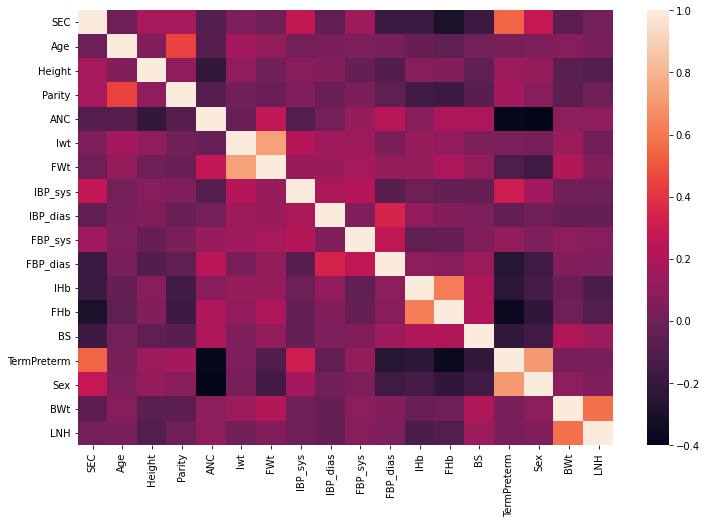

In [253]:
plt.figure(figsize=(12,8))
X_numeric = X.loc[:,~X.columns.isin(['Bgroup'])]
sns.heatmap(X_numeric.corr())
plt.show()

### 1.6.6. Točkasti dijagram

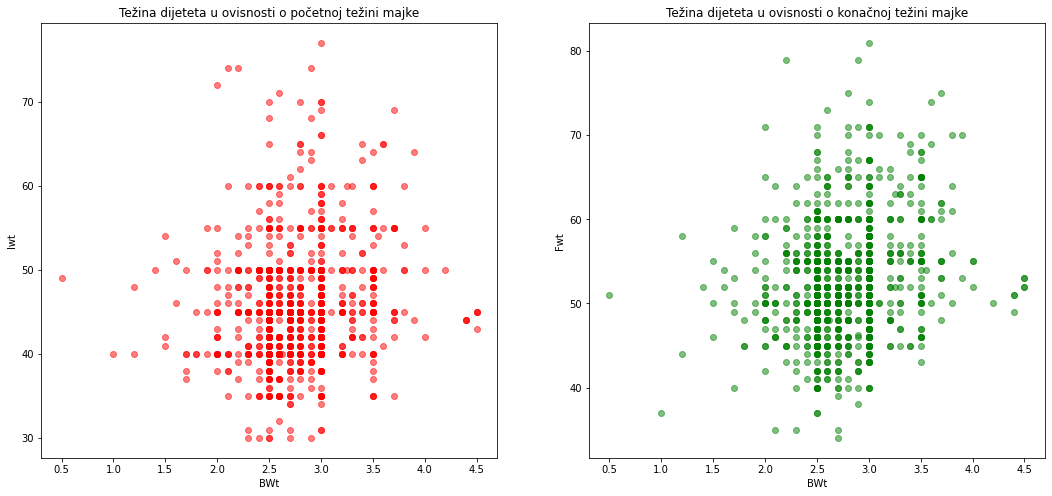

In [254]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.title('Težina dijeteta u ovisnosti o početnoj težini majke')
plt.scatter(X.BWt, X.Iwt, alpha=0.5, c='r')
plt.xlabel('BWt')
plt.ylabel('Iwt')

plt.subplot(1,2,2)
plt.title('Težina dijeteta u ovisnosti o konačnoj težini majke')
plt.scatter(X.BWt, X.FWt, alpha=0.5, c='g')
plt.xlabel('BWt')
plt.ylabel('Fwt')
plt.show()

Ne vidimo neke posebne međuovisnosti težine bebe i početne odnosno konačne težine majke.

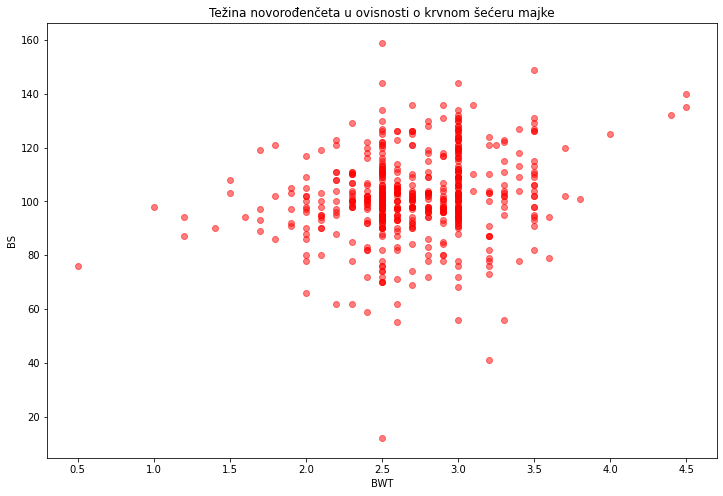

In [255]:
plt.figure(figsize=(12,8))
plt.title('Težina novorođenčeta u ovisnosti o krvnom šećeru majke')
plt.scatter(X.BWt, X.BS, alpha=0.5, c='r')
plt.xlabel('BWT')
plt.ylabel('BS')
plt.show()

Čini se da je težina bebe veća što je krvni šećer majke veći.

Pokušajmo odvojiti bebe ovisno o spolu i vidjeti postoje li značajne razlike u težinama beba u ovisnosti o karakteristikama majke.

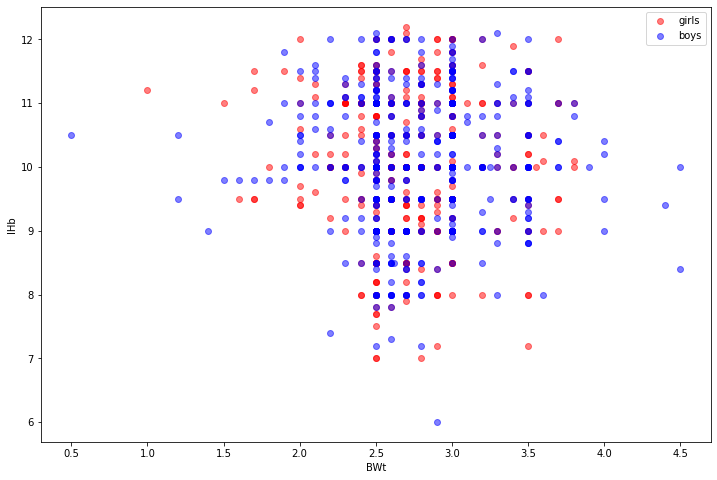

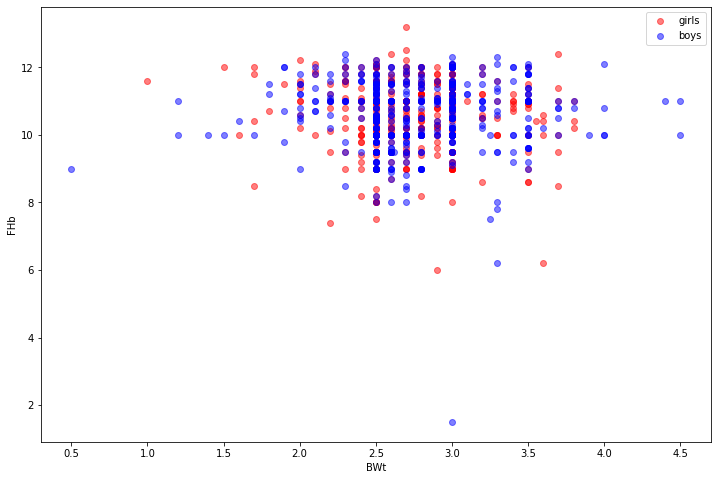

In [256]:
girls = X.Sex == 0# F
boys = X.Sex == 1# M

plt.figure(figsize=(12,8))
plt.scatter(X.loc[girls,'BWt'], X.loc[girls,'IHb'], alpha=0.5, c='r', label='girls')
plt.scatter(X.loc[boys,'BWt'], X.loc[boys,'IHb'], alpha=0.5, c='b', label='boys')
plt.xlabel('BWt')
plt.ylabel('IHb')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(X.loc[girls,'BWt'], X.loc[girls,'FHb'], alpha=0.5, c='r', label='girls')
plt.scatter(X.loc[boys,'BWt'], X.loc[boys,'FHb'], alpha=0.5, c='b', label='boys')
plt.xlabel('BWt')
plt.ylabel('FHb')
plt.legend(loc='best')
plt.show()

Ne primjećujemo posebnu zavisnost težine bebe o početnoj i konačnoj razini hemoglobina majke.

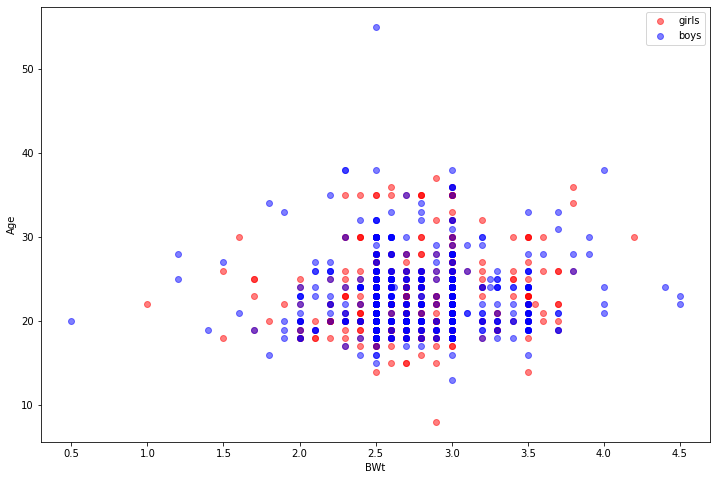

In [257]:
plt.figure(figsize=(12,8))
plt.scatter(X.loc[girls,'BWt'], X.loc[girls,'Age'], alpha=0.5, c='r', label='girls')
plt.scatter(X.loc[boys,'BWt'], X.loc[boys,'Age'], alpha=0.5, c='b', label='boys')
plt.xlabel('BWt')
plt.ylabel('Age')
plt.legend(loc='best')
plt.show()

Ne uočavamo posebnu zavisnost težine bebe o dobi majke.

## 1.7. Deskriptivna statistika

Metodom describe možemo dobiti prvi dojam deskriptivne statistike.

In [258]:
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SEC,1800.0,1.180000,0.714217,0.0,1.0,1.0,2.0,2.0
Age,1786.0,22.986002,4.050843,8.0,20.0,22.0,25.0,55.0
Height,1527.0,143.785855,19.702879,10.0,135.0,150.0,150.0,195.0
Parity,1767.0,0.667233,0.993277,0.0,0.0,0.0,1.0,6.0
ANC,1781.0,3.423358,0.889005,1.0,3.0,4.0,4.0,4.0
Iwt,1751.0,45.749857,6.655457,30.0,41.0,45.0,50.0,93.0
FWt,1739.0,51.645371,6.905943,30.0,47.0,51.0,55.0,100.0
IBP_sys,1760.0,108.032386,12.021658,10.0,100.0,110.0,112.0,196.0
IBP_dias,1760.0,66.091477,8.263232,14.0,60.0,66.0,70.0,100.0
FBP_sys,1749.0,111.819325,11.809435,10.0,110.0,110.0,120.0,160.0


Već u poglavlju prikaza podataka histogramima možemo vidjeti kako podaci imaju normalnu distribuciju (dob majki, visina majki, razina hemoglobina i sl.). Možemo još jednom prikazati distribuciju težina novorođenčati te njihovu srednju vrijednost i medijan.

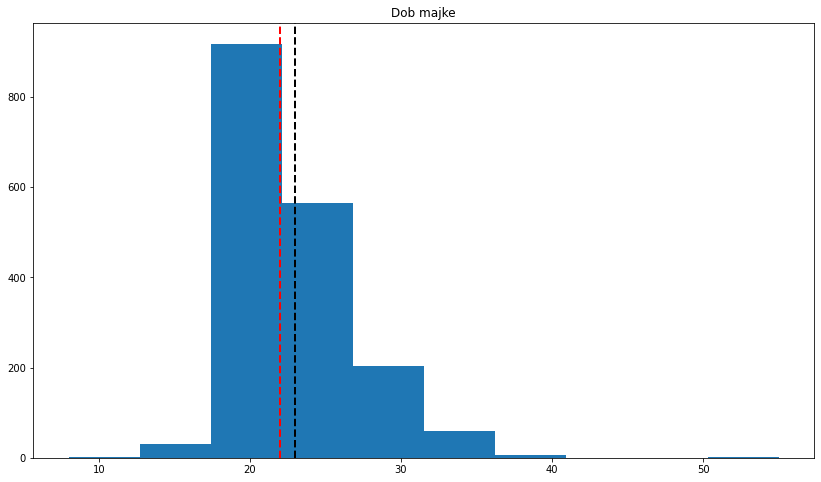

In [259]:
plt.figure(figsize=(14,8))
plt.hist(X.Age)
plt.title('Dob majke')
plt.axvline(X.Age.mean(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(X.Age.median(), color='red', linestyle='dashed', linewidth=2)

plt.show()

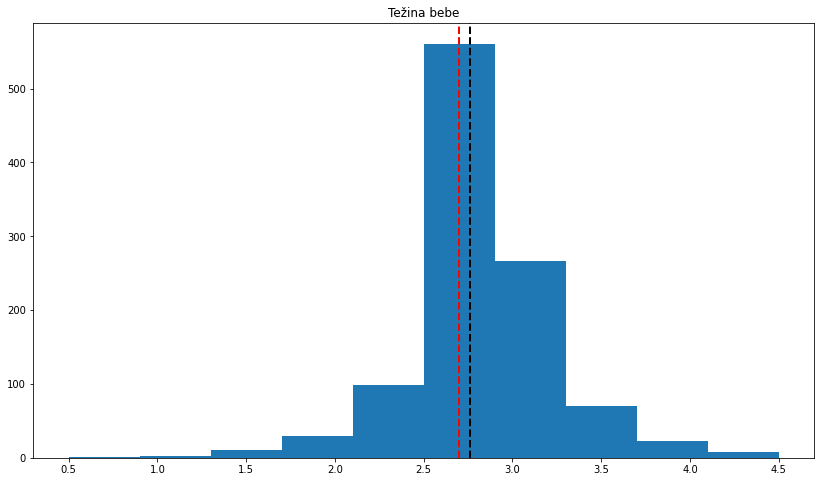

In [260]:
plt.figure(figsize=(14,8))
plt.hist(X.BWt)
plt.title('Težina bebe')
plt.axvline(X.BWt.mean(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(X.BWt.median(), color='red', linestyle='dashed', linewidth=2)

plt.show()

Nadalje ovisnost među značajkama možemo potvrditi ispitivanjem točnosti hipoteza. Stoga testirajmo ovisnost težine bebe o socioekonomskom statusu majke pomoću Z-testa.

In [261]:
from statsmodels.stats.weightstats import ztest as ztest

**Nulta hipoteza:** Socioekonomski status majke nije utjecao na težinu bebe.

**Alternativna hipoteza:** Socioekonomski status majke je utjecao na težinu bebe.

In [262]:
X.loc[X.LNH.isna(), 'LNH'] = round(X.loc[:,'LNH'].mean())

Apl = X.query('SEC == 0')
Bpl = X.query('SEC == 1')

apl_sample = Apl.sample(n=100, random_state=1)
bpl_sample = Bpl.sample(n=100, random_state=1)

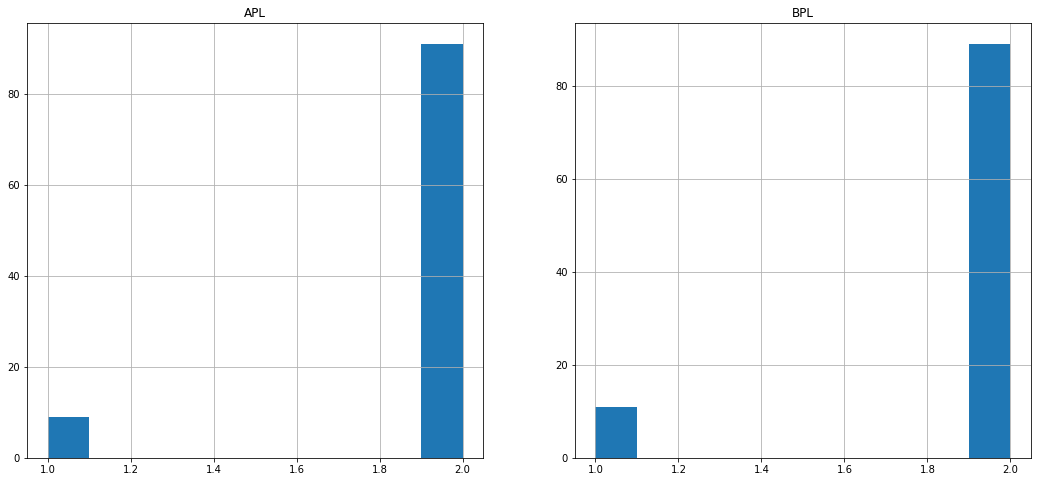

In [263]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.title('APL')
apl_sample['LNH'].hist()
plt.subplot(1,2,2)
plt.title('BPL')
bpl_sample['LNH'].hist()
plt.show()

In [264]:
LNH_normal = np.array([np.mean(X[X["SEC"]==0].sample(20)["LNH"].values) for i in range(100)])
apl_sample['LNH_normal'] = LNH_normal

LNH_normal_t = np.array([np.mean(X[X["SEC"]==1].sample(20)["LNH"].values) for i in range(100)])
bpl_sample['LNH_normal'] = LNH_normal_t

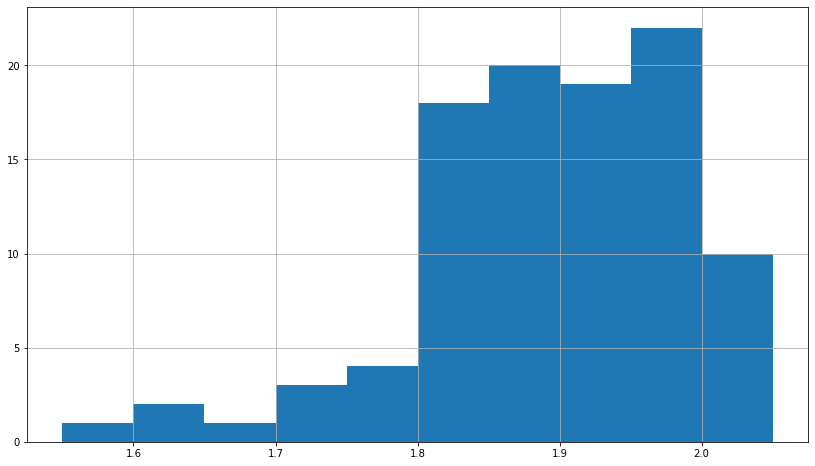

In [265]:
plt.figure(figsize=(14,8))
apl_sample['LNH_normal'].hist()

In [266]:
ztest(apl_sample['LNH_normal'], value=0)

(196.67433308921989, 0.0)

p-vrijednost je ispod 0.05 te stoga možemo odbaciti nultu hipotezu.

In [267]:
ztest(bpl_sample['LNH_normal'], value=0)

(296.50793836148955, 0.0)

p-vrijednost je ispod 0.05 te stoga možemo odbaciti nultu hipotezu

# 2. Replikacija rezultata

## 2.1. Uklanjamo stršeće vrijednosti

Kako bismo mogli kvalitetno učiti iz podataka potrebno je prethodno počistiti podatke od stršećih vrijednosti (outliers). Naime te vrijednosti su ili ekstremi ili nekakav šum iz kojih ne možemo dobro generalizirati.

In [268]:

X_tmp = X_tmp.loc[X_tmp.Age >= 10, :]
X_tmp = X_tmp.loc[ X_tmp.Age <= 33, :]

X_tmp = X_tmp.loc[X_tmp.Height >= 110, :]
X_tmp = X_tmp.loc[X_tmp.Height <= 175, :]

X_tmp = X_tmp.loc[X_tmp.Iwt >= 30, :]
X_tmp = X_tmp.loc[X_tmp.FWt >= 35, :]
X_tmp = X_tmp.loc[X_tmp.Iwt <= 65, :]
X_tmp = X_tmp.loc[X_tmp.FWt <= 70, :]

X_tmp = X_tmp.loc[X_tmp.IBP_sys >= 75, :]
X_tmp = X_tmp.loc[X_tmp.FBP_sys >= 90, :]
X_tmp = X_tmp.loc[X_tmp.IBP_dias >= 45, :]
X_tmp = X_tmp.loc[X_tmp.FBP_dias >= 40, :]
X_tmp = X_tmp.loc[X_tmp.IBP_sys <= 125, :]
X_tmp = X_tmp.loc[X_tmp.FBP_sys <= 130, :]
X_tmp = X_tmp.loc[X_tmp.IBP_dias <= 85, :]
X_tmp = X_tmp.loc[X_tmp.FBP_dias <= 100, :]

X_tmp = X_tmp.loc[X_tmp.IHb >= 8, :]
X_tmp = X_tmp.loc[X_tmp.FHb >= 8, :]
X_tmp = X_tmp.loc[X_tmp.IHb <= 12, :]
X_tmp = X_tmp.loc[X_tmp.FHb <= 13, :]

X_tmp = X_tmp.loc[X_tmp.BWt >= 2, :]
X_tmp = X_tmp.loc[X_tmp.BWt <= 4, :]

### Provjera uklonjenih stršećih vrijednosti

Kako bismo provjerili uspješnost prethodnog koraka možemo sagledati preostale podatke kroz kutijaste dijagrame.

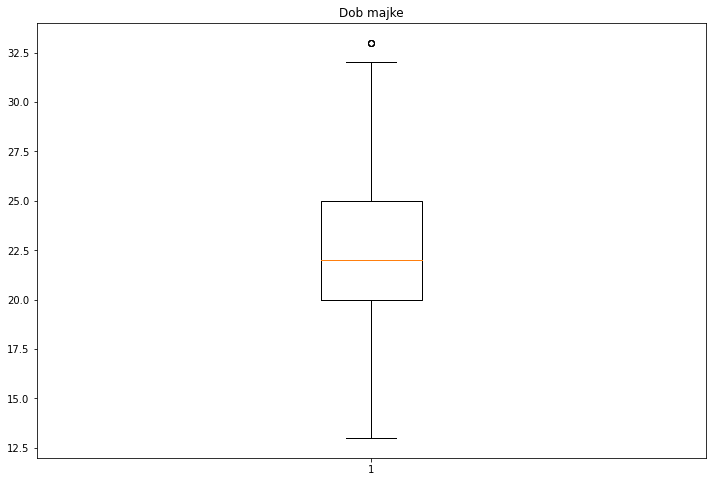

In [269]:
plt.figure(figsize=(12,8))
plt.boxplot(X_tmp.Age)
plt.title('Dob majke')
plt.show()

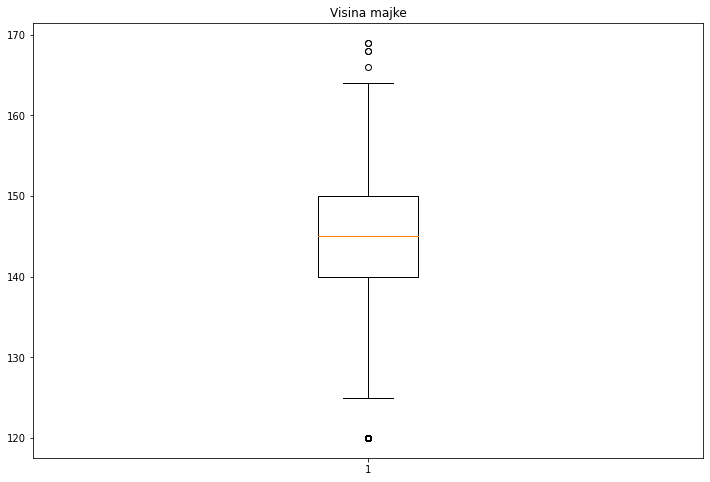

In [270]:
plt.figure(figsize=(12,8))
plt.boxplot(X_tmp.Height)
plt.title('Visina majke')
plt.show()

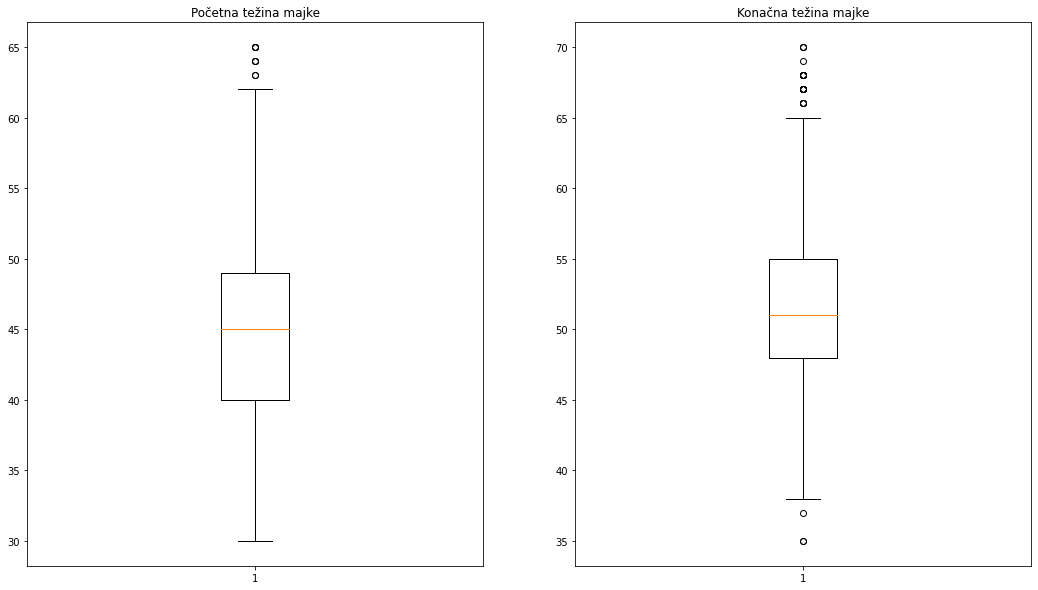

In [271]:
plt.figure(figsize=(18,10))
plt.subplot(1, 2, 1)
plt.boxplot(X_tmp.Iwt)
plt.title('Početna težina majke')
plt.subplot(1, 2, 2)
plt.boxplot(X_tmp.FWt)
plt.title('Konačna težina majke')
plt.show()

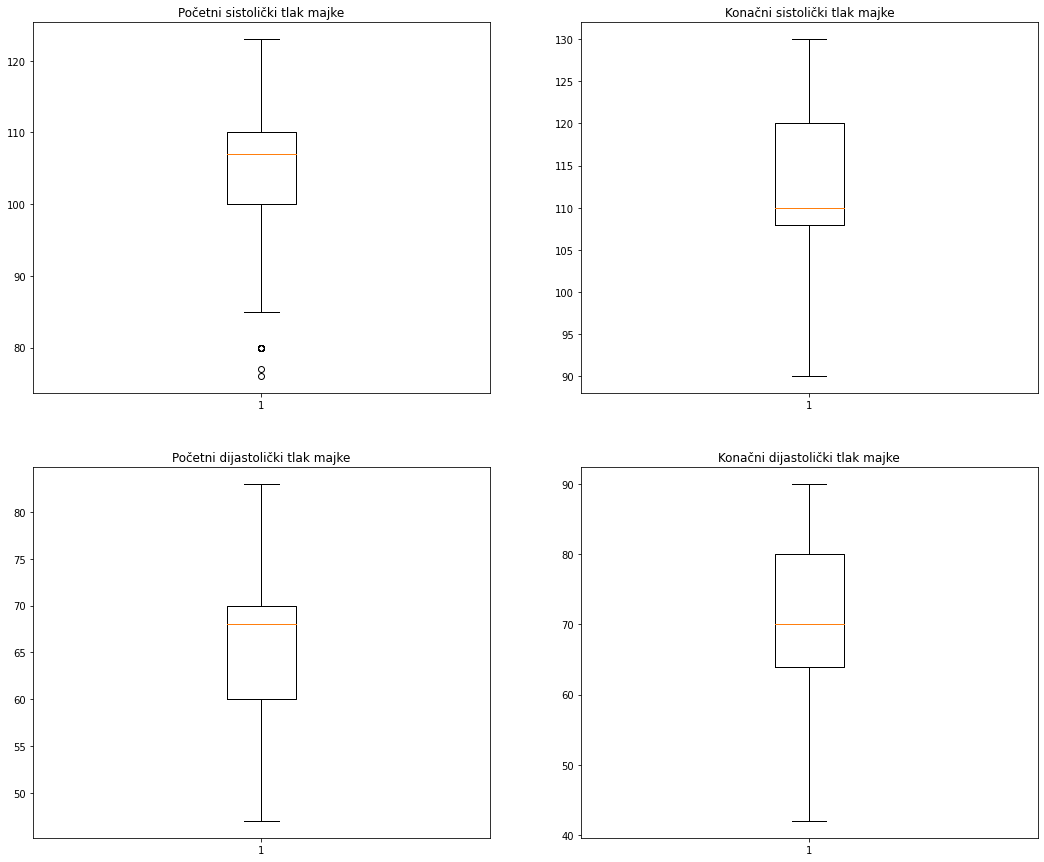

In [272]:
plt.figure(figsize=(18,15))
plt.subplot(2, 2, 1)
plt.boxplot(X_tmp.IBP_sys)
plt.title('Početni sistolički tlak majke')
plt.subplot(2, 2, 2)
plt.boxplot(X_tmp.FBP_sys)
plt.title('Konačni sistolički tlak majke')
plt.subplot(2, 2, 3)
plt.boxplot(X_tmp.IBP_dias)
plt.title('Početni dijastolički tlak majke')
plt.subplot(2, 2, 4)
plt.boxplot(X_tmp.FBP_dias)
plt.title('Konačni dijastolički tlak majke')
plt.show()

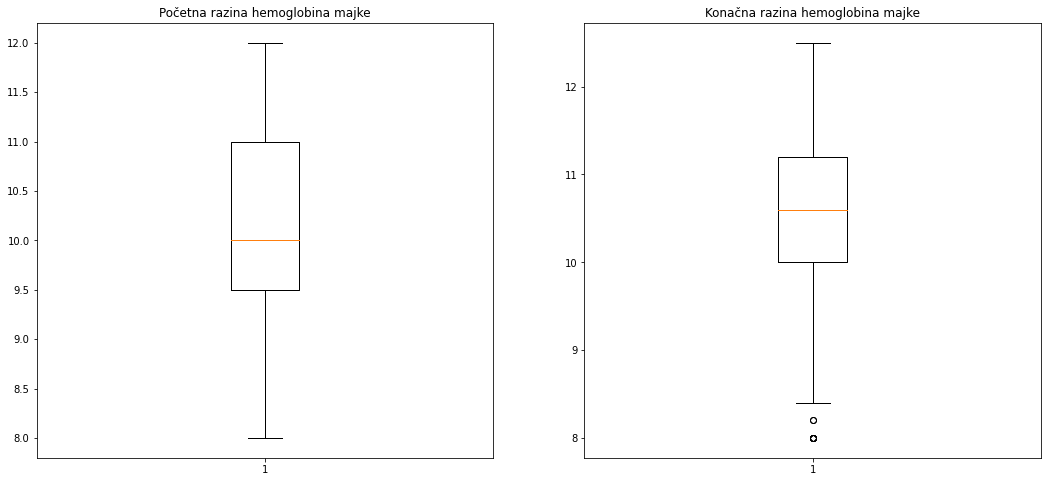

In [273]:
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
plt.boxplot(X_tmp.IHb)
plt.title('Početna razina hemoglobina majke')
plt.subplot(1, 2, 2)
plt.boxplot(X_tmp.FHb)
plt.title('Konačna razina hemoglobina majke')
plt.show()

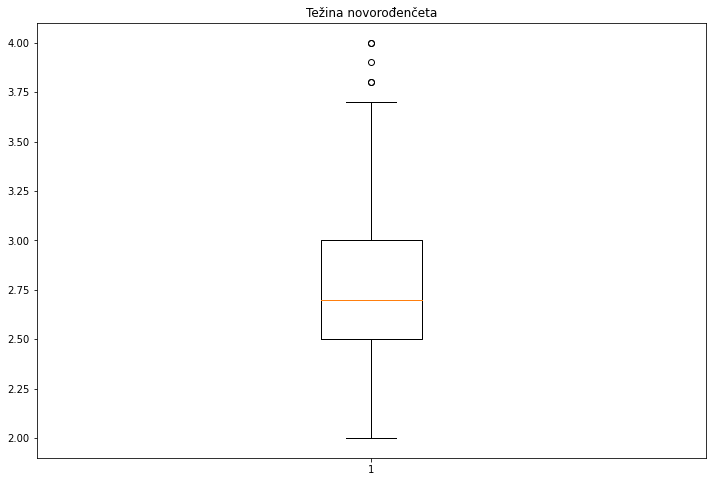

In [274]:
plt.figure(figsize=(12,8))
plt.boxplot(X_tmp.BWt)
plt.title('Težina novorođenčeta')
plt.show()

## 2.2. Gaussov naivni Bayes klasifikator (Gaussian naive Bayes)

Trenutno naš skup podataka ima slijedeći izgled.

In [275]:
X = X_tmp.copy()
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,803.0,22.413397,3.577898,13.0,20.0,22.000000,25.0,33.0
Height,803.0,142.881535,11.230160,120.0,140.0,145.000000,150.0,169.0
Parity,803.0,0.555417,0.879444,0.0,0.0,0.000000,1.0,6.0
ANC,803.0,3.755915,0.611771,1.0,4.0,4.000000,4.0,4.0
Iwt,803.0,45.056040,6.033415,30.0,40.0,45.000000,49.0,65.0
FWt,803.0,52.123661,6.057415,35.0,48.0,51.000000,55.0,70.0
IBP_sys,803.0,105.357410,8.570554,76.0,100.0,107.000000,110.0,123.0
IBP_dias,803.0,66.105853,6.877627,47.0,60.0,68.000000,70.0,83.0
FBP_sys,803.0,111.236613,8.247651,90.0,108.0,110.000000,120.0,130.0
FBP_dias,803.0,70.920299,8.028231,42.0,64.0,70.000000,80.0,90.0


Iz skupa podataka posebno izdvajamo izlaznu oznaku (y) koju ćemo htjeti predvidjeti.

In [276]:
y = X.LNH
print(y.values)
print(len(y.values))

[1. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 1. 2. 1. 1. 2. 2. 1. 2. 2. 1. 2.
 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 1. 2. 1. 2. 1. 2. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 1. 2.
 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 2. 1.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2.
 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 1. 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 1. 1. 2. 2. 2. 1. 2. 2. 2. 1. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 1. 2. 2. 2. 1. 1. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 1. 1. 2.
 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2.

Ulazni skup, odnosno primjeri sa svojim značajkama pohranjeni su u X.

In [277]:
X.drop(['LNH'], axis=1, inplace=True)
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,803.0,22.413397,3.577898,13.0,20.0,22.000000,25.0,33.0
Height,803.0,142.881535,11.230160,120.0,140.0,145.000000,150.0,169.0
Parity,803.0,0.555417,0.879444,0.0,0.0,0.000000,1.0,6.0
ANC,803.0,3.755915,0.611771,1.0,4.0,4.000000,4.0,4.0
Iwt,803.0,45.056040,6.033415,30.0,40.0,45.000000,49.0,65.0
FWt,803.0,52.123661,6.057415,35.0,48.0,51.000000,55.0,70.0
IBP_sys,803.0,105.357410,8.570554,76.0,100.0,107.000000,110.0,123.0
IBP_dias,803.0,66.105853,6.877627,47.0,60.0,68.000000,70.0,83.0
FBP_sys,803.0,111.236613,8.247651,90.0,108.0,110.000000,120.0,130.0
FBP_dias,803.0,70.920299,8.028231,42.0,64.0,70.000000,80.0,90.0


Kako bismo pokušali replicirati rezultate članka potrebno je prvo definirati skup za učenje i skup za ispitivanje. Tipično se skupovi slučajno biraju nad skupom primjera u omjeru 60:40 ili 70:30. Biramo omjer 70:30 pošto je isti korišten u članku.

In [278]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=7)

Prvi pristup koji koristimo za predviđanje izlazne oznake neviđenih primjera je Gaussov naivni Bayes klasifikator. Jednom kad smo učitali model treniramo ga nad skupom za učenje te tako trenirani model koristimo za predviđanje izlaza skupa za ispitivanje. 

Nadalje možemo provjeriti performanse modela, a jedan tipičan način provjere jest izračun točnosti (accuracy).

In [279]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

model = GaussianNB()
model.fit(X_train, y_train)

print("Accuracy:")
print("training (%) = ", round(accuracy_score(y_train, model.predict(X_train)), 4)*100)
print("testing (%) = ", round(accuracy_score(y_test, model.predict(X_test)), 4)*100)


Accuracy:
training (%) =  96.25
testing (%) =  91.64999999999999


Uz točnost možemo izračunati: 
- preciznost, PR (precision) -> mjera izvedbe pojedine klase
- recall, RE -> omjer uzoraka klase koja je točno predviđena
- f1 score -> harmonijska sredina PR i RE

In [280]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("Precision:")
print("(class = L): ", round(precision_score(y, model.predict(X), labels=['L', 'N'], pos_label=1, average='binary'), 3))
print("(class = N): ", round(precision_score(y, model.predict(X), labels=['L', 'N'], pos_label=2, average='binary'), 3))

print("\nRecall:")
print("(class = L): ", round(recall_score(y, model.predict(X), labels=['L', 'N'], pos_label=1, average='binary'), 3))
print("(class = N): ", round(recall_score(y, model.predict(X), labels=['L', 'N'], pos_label=2, average='binary'), 3))

print("\nF1:")
print("(class = L): ", round(f1_score(y, model.predict(X), labels=['L', 'N'], pos_label=1, average='binary'), 3))
print("(class = N): ", round(f1_score(y, model.predict(X), labels=['L', 'N'], pos_label=2, average='binary'), 3))

Precision:
(class = L):  0.754
(class = N):  0.945

Recall:
(class = L):  0.529
(class = N):  0.979

F1:
(class = L):  0.622
(class = N):  0.962


Možemo usporediti dobivene mjere s onima prezentiranim u članku. Dobivena točnost Gaussovog naivnog klasifikatora je većeg iznosa od točnosti u članku. Preciznost, recall i f1-score su sličnog iznosa za izlaznu oznaku L te nešto većeg iznosa za izlaznu oznaku N.

Još jedan način provjere performanse modela je matrica zabune (confusion matrix). Matrica navodi broj primjera koji su true positive (TP), false positive (FP), false negative (FN) i true negative (TN). Vrijednosti na dijagonali bi trebale biti što veće odnosno vrijednosti van dijagonale bi trebale biti što bliže nuli. 

In [281]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, model.predict(X_test))

array([[ 26,  35],
       [ 12, 490]])

Imamo 26 primjera koji su klasificirani kao L, a zapravo su N te 27 primjera koji su klasificirani kao N, a zapravo su L. 

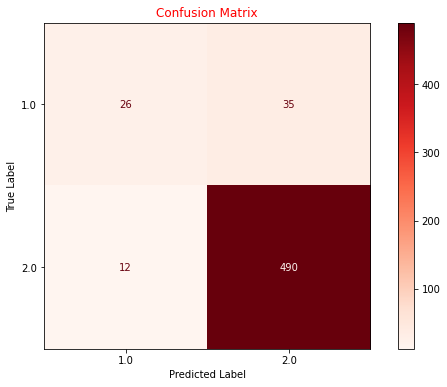

In [282]:
from sklearn.metrics import plot_confusion_matrix

matrix = plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Reds)
matrix.ax_.set_title('Confusion Matrix',color='red')
plt.xlabel('Predicted Label',color='black')
plt.ylabel('True Label',color='black')
plt.gcf().axes[0].tick_params(color="black")
plt.gcf().axes[1].tick_params(color="black")
plt.gcf().set_size_inches(10,6)

ROC krivulja je grafički prikaz izvedbe binarnog klasifikatora kao funkcija različitih pragova korištenih pri klasifikaciji, dok AUC predstavlja površinu ispod krivulje. Funkcijom roc_auc_score možemo vidjeti kolika je površina ispod ROC krivulje. Što je model točniji, odnosno što bolje predviđa to je ta vrijednost bliža 1.

In [283]:
from sklearn.metrics import roc_auc_score

round(roc_auc_score(y.values, model.predict_proba(X)[:, 1]), 4)

0.9525

## 2.3. Slučajna šuma (Random forest)

Drugi pristup koji koristimo je slučajna šuma. Prvo treniramo model na skupu za učenje te zatim predviđamo izlazne oznake na skupu za ispitivanje.

In [284]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(max_depth=4, random_state=0)
random_forest.fit(X_train, y_train)

print("Accuracy:")
print("training (%) = ", round(accuracy_score(y_train, random_forest.predict(X_train)), 4)*100)
print("testing (%) = ", round(accuracy_score(y_test, random_forest.predict(X_test)), 4)*100)

Accuracy:
training (%) =  100.0
testing (%) =  99.64


In [285]:
print("Precision:")
print("(class = L): ", round(precision_score(y, random_forest.predict(X), labels=['L', 'N'], pos_label=1, average='binary'), 3))
print("(class = N): ", round(precision_score(y, random_forest.predict(X), labels=['L', 'N'], pos_label=2, average='binary'), 3))

print("\nRecall:")
print("(class = L): ", round(recall_score(y, random_forest.predict(X), labels=['L', 'N'], pos_label=1, average='binary'), 3))
print("(class = N): ", round(recall_score(y, random_forest.predict(X), labels=['L', 'N'], pos_label=2, average='binary'), 3))

print("\nF1:")
print("(class = L): ", round(f1_score(y, random_forest.predict(X), labels=['L', 'N'], pos_label=1, average='binary'), 3))
print("(class = N): ", round(f1_score(y, random_forest.predict(X), labels=['L', 'N'], pos_label=2, average='binary'), 3))

Precision:
(class = L):  0.989
(class = N):  0.999

Recall:
(class = L):  0.989
(class = N):  0.999

F1:
(class = L):  0.989
(class = N):  0.999


Dobivena točnost, preciznost, recall i f1-score slučajne šume je nešto manji nego li u članku. No razlog tomu može biti kako smo pripremili podatke (stršeće vrijednosti, nedostajuće vrijednosti) te koji podaci su odabrani za učenje.

In [286]:
confusion_matrix(y_test, random_forest.predict(X_test))

array([[ 60,   1],
       [  1, 501]])

Svega 7 primjera je klasificirano kao L dok zapravo pripadaju klasi N i 1 primjer je klasificiran kao N dok zapravo pripada klasi L.

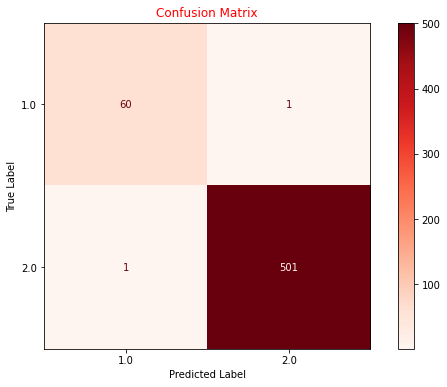

In [287]:
matrix = plot_confusion_matrix(random_forest, X_test, y_test,cmap=plt.cm.Reds)
matrix.ax_.set_title('Confusion Matrix',color='red')
plt.xlabel('Predicted Label',color='black')
plt.ylabel('True Label',color='black')
plt.gcf().axes[0].tick_params(color="black")
plt.gcf().axes[1].tick_params(color="black")
plt.gcf().set_size_inches(10,6)

Roc_auc_score je također visok, odnosno blizu 1 što znači da naš model dosta dobro predviđa.

In [288]:
round(roc_auc_score(y.values, random_forest.predict_proba(X)[:, 1]), 4)

0.9931

# 3. Poboljšanje rezultata

In [289]:
X.head()

,Age,Height,Parity,ANC,Iwt,FWt,IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb,FHb,BS,BWt
2,24.0,155.0,1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,2.4
3,19.0,154.0,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,2.6
4,21.0,150.0,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,2.3
5,19.0,150.0,0.0,4.0,44.0,54.0,100.0,70.0,120.0,80.0,9.0,9.8,93.0,2.5
6,15.0,147.0,0.0,4.0,37.0,45.0,80.0,50.0,90.0,70.0,8.9,10.0,97.0,2.5


In [290]:
X_train.drop(['BWt'], axis=1, inplace=True)
X_test.drop(['BWt'], axis=1, inplace=True)
X.drop(['BWt'], axis=1, inplace=True)

In [291]:
X_train.head()

,Age,Height,Parity,ANC,Iwt,FWt,IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb,FHb,BS
222,20.0,146.0,0.0,4.0,45.0,48.0,110.0,70.0,100.0,70.0,11.400000,11.400000,109.000000
225,18.0,146.0,0.0,4.0,45.0,51.0,100.0,70.0,100.0,60.0,11.600000,12.000000,96.000000
547,26.0,120.0,0.0,4.0,49.0,52.0,111.0,62.0,112.0,62.0,9.500000,11.000000,100.898026
868,30.0,150.0,2.0,3.0,36.0,50.0,120.0,60.0,120.0,60.0,9.919398,10.401651,100.898026
511,19.0,143.0,0.0,4.0,40.0,40.0,100.0,60.0,100.0,60.0,8.500000,9.500000,103.000000


## 3.1. Gaussov naivni Bayes klasifikator (Gaussian naive Bayes)

In [292]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=7)

In [293]:
model = GaussianNB()
model.fit(X_train, y_train)

print("Accuracy:")
print("training (%) = ", round(accuracy_score(y_train, model.predict(X_train)), 4)*100)
print("testing (%) = ", round(accuracy_score(y_test, model.predict(X_test)), 4)*100)

Accuracy:
training (%) =  90.0
testing (%) =  84.37


In [294]:
confusion_matrix(y_test, model.predict(X_test))

array([[  8,  53],
       [ 35, 467]])

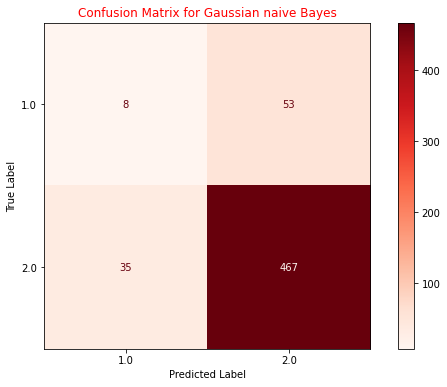

In [295]:
matrix = plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Reds)
matrix.ax_.set_title('Confusion Matrix for Gaussian naive Bayes',color='red')
plt.xlabel('Predicted Label',color='black')
plt.ylabel('True Label',color='black')
plt.gcf().axes[0].tick_params(color="black")
plt.gcf().axes[1].tick_params(color="black")
plt.gcf().set_size_inches(10,6)

In [296]:
round(roc_auc_score(y.values, model.predict_proba(X)[:, 1]), 4)

0.7334

## 3.2. Slučajna šuma (Random forest)

In [297]:
from sklearn.model_selection import cross_val_predict
d = [n for n in range(1, 21)]

accuracy_scores = []
f1_scores = []
best_d = 0
bestacc = 0 
bestf1 = 0

number_trees = [n for n in range(1, 21)]
best_nt = 0

for d_i in d:
  for nt in number_trees:
    clf = RandomForestClassifier(max_depth=d_i, random_state=0,  n_estimators=nt)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

    if accuracy_score(y_test, y_pred) > bestacc and f1_score(y_test, y_pred) > bestf1:
      best_d = d_i
      best_nt = nt
      bestacc = accuracy_score(y_test, y_pred)
      bestf1 = f1_score(y_test, y_pred)

print("best depth: ", best_d)
print("best number of trees: ", best_nt)

best depth:  5
best number of trees:  3


In [298]:
random_forest = RandomForestClassifier(max_depth=best_d, random_state=0, n_estimators=best_nt)
random_forest.fit(X_train, y_train)

print("Accuracy:")
print("training (%) = ", round(accuracy_score(y_train, random_forest.predict(X_train)), 4)*100)
print("testing (%) = ", round(accuracy_score(y_test, random_forest.predict(X_test)), 4)*100)

Accuracy:
training (%) =  92.08
testing (%) =  87.21


In [299]:
print("Precision:")
print("(class = L): ", round(precision_score(y, random_forest.predict(X), labels=['L', 'N'], pos_label=1, average='binary'), 3))
print("(class = N): ", round(precision_score(y, random_forest.predict(X), labels=['L', 'N'], pos_label=2, average='binary'), 3))

print("\nRecall:")
print("(class = L): ", round(recall_score(y, random_forest.predict(X), labels=['L', 'N'], pos_label=1, average='binary'), 3))
print("(class = N): ", round(recall_score(y, random_forest.predict(X), labels=['L', 'N'], pos_label=2, average='binary'), 3))

print("\nF1:")
print("(class = L): ", round(f1_score(y, random_forest.predict(X), labels=['L', 'N'], pos_label=1, average='binary'), 3))
print("(class = N): ", round(f1_score(y, random_forest.predict(X), labels=['L', 'N'], pos_label=2, average='binary'), 3))

Precision:
(class = L):  0.409
(class = N):  0.9

Recall:
(class = L):  0.103
(class = N):  0.982

F1:
(class = L):  0.165
(class = N):  0.939


In [300]:
confusion_matrix(y_test, random_forest.predict(X_test))

array([[  1,  60],
       [ 12, 490]])

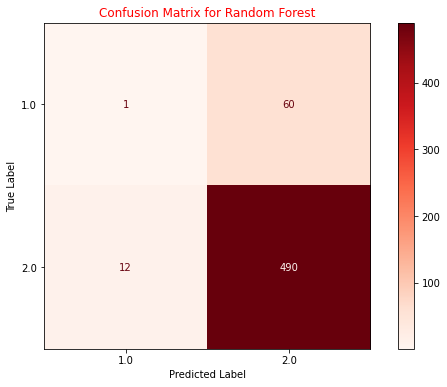

In [301]:
matrix = plot_confusion_matrix(random_forest, X_test, y_test,cmap=plt.cm.Reds)
matrix.ax_.set_title('Confusion Matrix for Random Forest',color='red')
plt.xlabel('Predicted Label',color='black')
plt.ylabel('True Label',color='black')
plt.gcf().axes[0].tick_params(color="black")
plt.gcf().axes[1].tick_params(color="black")
plt.gcf().set_size_inches(10,6)

In [302]:
round(roc_auc_score(y.values, random_forest.predict_proba(X)[:, 1]), 4)

0.7406

## 3.3. KNN

In [303]:
from sklearn.neighbors import KNeighborsClassifier

def knn_eval(X_train, y_train, X_test, y_test):
    
    train_errors = []
    test_errors = []
    ks = list(range(1, 21))

    for i in range(0, 40):
        train = []
        test = []
        for k in ks:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            train.append(1 - knn.score(X_train, y_train))
            test.append(1 - knn.score(X_test, y_test))
        train_errors.append(train)
        test_errors.append(test)
        
    train_errors = np.mean(np.array(train_errors), axis=0)
    test_errors = np.mean(np.array(test_errors), axis=0)
    best_k = ks[np.argmin(test_errors)]
    
    return ks, best_k, train_errors, test_errors

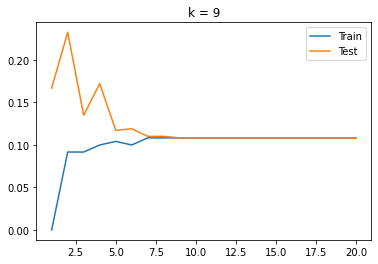

In [304]:
ks, best_k, train_errors, test_errors = knn_eval(X_train, y_train, X_test, y_test)
plt.plot(ks, train_errors, label = "Train")
plt.plot(ks, test_errors, label = "Test")
plt.title("k = " + str(best_k))
plt.legend()
plt.show()

In [305]:
knn_model = KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train)

print("Accuracy:")
print("training (%) = ", round(accuracy_score(y_train, knn_model.predict(X_train)), 4)*100)
print("testing (%) = ", round(accuracy_score(y_test, knn_model.predict(X_test)), 4)*100)

Accuracy:
training (%) =  89.17
testing (%) =  89.17


In [306]:
knn_predictions = knn_model.predict(X_test)
print("Precision Score : ",precision_score(y_test,knn_predictions,average='micro'))
print("Recall Score : ",recall_score(y_test, knn_predictions,average='micro'))
print("F1_score: ",f1_score(y_test,knn_predictions,average='micro'))

Precision Score :  0.8916518650088809
Recall Score :  0.8916518650088809
F1_score:  0.8916518650088809


In [307]:
print("Precision:")
print("(class = L): ", round(precision_score(y, knn_model.predict(X), labels=['L', 'N'], pos_label=1, average='binary'), 3))
print("(class = N): ", round(precision_score(y, knn_model.predict(X), labels=['L', 'N'], pos_label=2, average='binary'), 3))

print("\nRecall:")
print("(class = L): ", round(recall_score(y, knn_model.predict(X), labels=['L', 'N'], pos_label=1, average='binary'), 3))
print("(class = N): ", round(recall_score(y, knn_model.predict(X), labels=['L', 'N'], pos_label=2, average='binary'), 3))

print("\nF1:")
print("(class = L): ", round(f1_score(y, knn_model.predict(X), labels=['L', 'N'], pos_label=1, average='binary'), 3))
print("(class = N): ", round(f1_score(y, knn_model.predict(X), labels=['L', 'N'], pos_label=2, average='binary'), 3))

Precision:
(class = L):  0.0
(class = N):  0.892

Recall:
(class = L):  0.0
(class = N):  1.0

F1:
(class = L):  0.0
(class = N):  0.943


In [308]:
confusion_matrix(y_test, knn_model.predict(X_test))

array([[  0,  61],
       [  0, 502]])

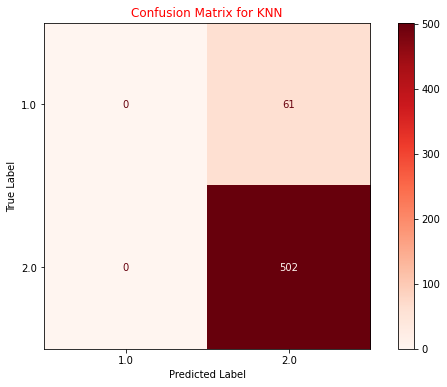

In [309]:
matrix = plot_confusion_matrix(knn_model, X_test, y_test,cmap=plt.cm.Reds)
matrix.ax_.set_title('Confusion Matrix for KNN',color='red')
plt.xlabel('Predicted Label',color='black')
plt.ylabel('True Label',color='black')
plt.gcf().axes[0].tick_params(color="black")
plt.gcf().axes[1].tick_params(color="black")
plt.gcf().set_size_inches(10,6)

In [310]:
round(roc_auc_score(y.values, knn_model.predict_proba(X)[:, 1]), 4)

0.672